In [1]:
import numpy as np
import pandas as pd 
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from wordcloud import WordCloud
import string
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense, Input, SpatialDropout1D, Bidirectional, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
import keras_tuner
import os

SEED = 42
TEST_SIZE = 13818
#portions of this notebook were written with the assistance of Claude Sonnet 4

2025-06-20 12:09:22.423811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750421362.638322      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750421362.700379      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Natural Language Processing with Recurrent Neural Networks

## Problem Description

This project is being completed as part of the Deep Learning course in the CU Boulder Masters of Data Science program. The goal of the project is to utilize natural language processing (NLP) methodologies in combination with a Recurrent Neural Network (RNN) to perform binary classification of tweets; tweets will be classified as either referring to a real disaster or not. 

## Data Description

### Dataset Overwiew

* Source: Kagle "Natural Language Processing with Disaster Tweets" competition
* Purpose: "Predict which Tweets are about real disasters and which ones are not"
* Link: https://www.kaggle.com/c/nlp-getting-started/overview

### Dataset Size and Scope
* Total samples: 10,876 tweets
* Train set: 7,613 tweets
* Test set: 3,263 tweets
* Features: 5 columns

### Data Structure
#### Training Data Columns:
* `id`: Unique identifier for each tweet
* `text`: The content of the tweet
* `keyword`: A keyword from the tweet (may be blank)
* `location`: The location of the tweet (may be blank)
* `target`: Binary (1 = disaster, 0 = not disaster)
#### Test Data Columns:
* Same as training minus target column
### Data Characteristics
* Tweet length: Range of 7-157 characters, median = 107 characters
* Missing values: 33% missing in location, .8% missing in keyword
* Class distribution: 43% disaster tweets, 57% non-disaster tweets

## EDA

### Initial Data Overview

In [2]:
#Load datasets
data = Path('/kaggle/input/nlp-getting-started')
train = data/'train.csv'
test = data/'test.csv'

train_df = pd.read_csv(train)
test_df = pd.read_csv(test)

In [3]:
#data overview functions
def perform_initial_data_overview(train_df, test_df=None, save_plots=False):
    """
    Perform comprehensive initial data overview for disaster tweets dataset
    
    Args:
        train_df: Training DataFrame
        test_df: Test DataFrame (optional)
        save_plots: Whether to save plots to files
        
    Returns:
        dict: Summary statistics and insights
    """
    
    print("=" * 80)
    print("INITIAL DATA OVERVIEW - DISASTER TWEETS CLASSIFICATION")
    print("=" * 80)
    
    overview_stats = {}
    
    # 1. BASIC DATASET INFORMATION
    print("\n1. BASIC DATASET INFORMATION")
    print("-" * 50)
    
    print(f"Training set shape: {train_df.shape}")
    if test_df is not None:
        print(f"Test set shape: {test_df.shape}")
        print(f"Total samples: {len(train_df) + len(test_df):,}")
    
    print(f"\nTraining set columns: {list(train_df.columns)}")
    print(f"Training set dtypes:")
    print(train_df.dtypes)
    
    overview_stats['train_shape'] = train_df.shape
    if test_df is not None:
        overview_stats['test_shape'] = test_df.shape
    
    # 2. MISSING VALUES ANALYSIS
    print("\n2. MISSING VALUES ANALYSIS")
    print("-" * 40)
    
    train_missing = train_df.isnull().sum()
    train_missing_pct = (train_df.isnull().sum() / len(train_df)) * 100
    
    missing_summary = pd.DataFrame({
        'Missing_Count': train_missing,
        'Missing_Percentage': train_missing_pct
    })
    
    print("Training set missing values:")
    print(missing_summary)
    
    if test_df is not None:
        test_missing = test_df.isnull().sum()
        test_missing_pct = (test_df.isnull().sum() / len(test_df)) * 100
        
        print(f"\nTest set missing values:")
        test_missing_summary = pd.DataFrame({
            'Missing_Count': test_missing,
            'Missing_Percentage': test_missing_pct
        })
        print(test_missing_summary)
    
    overview_stats['missing_values'] = missing_summary.to_dict()
    
    # 3. TARGET VARIABLE ANALYSIS
    print("\n3. TARGET VARIABLE ANALYSIS")
    print("-" * 35)
    
    if 'target' in train_df.columns:
        target_counts = train_df['target'].value_counts().sort_index()
        target_pct = train_df['target'].value_counts(normalize=True).sort_index() * 100
        
        print("Target distribution:")
        for target, count in target_counts.items():
            pct = target_pct[target]
            label = "Disaster" if target == 1 else "Non-disaster"
            print(f"  {target} ({label}): {count:,} samples ({pct:.1f}%)")
        
        # Calculate class imbalance ratio
        minority_class = target_counts.min()
        majority_class = target_counts.max()
        imbalance_ratio = majority_class / minority_class
        
        print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
        
        overview_stats['target_distribution'] = target_counts.to_dict()
        overview_stats['class_imbalance_ratio'] = imbalance_ratio
    
    # 4. TEXT FEATURE ANALYSIS
    print("\n4. TEXT FEATURE ANALYSIS")
    print("-" * 30)
    
    if 'text' in train_df.columns:
        # Text length statistics
        train_df_copy = train_df.copy()
        train_df_copy['text_length'] = train_df_copy['text'].str.len()
        train_df_copy['word_count'] = train_df_copy['text'].str.split().str.len()
        
        text_stats = train_df_copy[['text_length', 'word_count']].describe()
        print("Text statistics:")
        print(text_stats)
        
        # Text length by class
        if 'target' in train_df.columns:
            print(f"\nText length by class:")
            for target in sorted(train_df['target'].unique()):
                class_data = train_df_copy[train_df_copy['target'] == target]
                label = "Disaster" if target == 1 else "Non-disaster"
                print(f"  {label} tweets:")
                print(f"    Mean length: {class_data['text_length'].mean():.1f} chars")
                print(f"    Mean words: {class_data['word_count'].mean():.1f} words")
        
        overview_stats['text_stats'] = text_stats.to_dict()
        
        # Empty or very short texts
        empty_texts = (train_df['text'].str.strip() == '').sum()
        very_short_texts = (train_df_copy['text_length'] < 10).sum()


In [4]:
perform_initial_data_overview(train_df, test_df)

INITIAL DATA OVERVIEW - DISASTER TWEETS CLASSIFICATION

1. BASIC DATASET INFORMATION
--------------------------------------------------
Training set shape: (7613, 5)
Test set shape: (3263, 4)
Total samples: 10,876

Training set columns: ['id', 'keyword', 'location', 'text', 'target']
Training set dtypes:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

2. MISSING VALUES ANALYSIS
----------------------------------------
Training set missing values:
          Missing_Count  Missing_Percentage
id                    0            0.000000
keyword              61            0.801261
location           2533           33.272035
text                  0            0.000000
target                0            0.000000

Test set missing values:
          Missing_Count  Missing_Percentage
id                    0            0.000000
keyword              26            0.796813
location           1105           33.864542
text                 

### Target Variable Analysis

In [5]:
#Target EDA functions
def perform_target_eda(df, save_plots=False):
    """
    Perform comprehensive EDA specifically for the target variable
    
    Args:
        df: DataFrame containing target variable and features
        save_plots: Whether to save plots to files
        
    Returns:
        dict: Target analysis results and insights
    """
    
    print("=" * 70)
    print("TARGET VARIABLE EDA - DISASTER TWEETS CLASSIFICATION")
    print("=" * 70)
    
    target_analysis = {}
    
    # 1. BASIC TARGET DISTRIBUTION
    print("\n1. BASIC TARGET DISTRIBUTION")
    print("-" * 35)
    
    if 'target' not in df.columns:
        raise ValueError("Dataset must contain 'target' column")
    
    target_counts = df['target'].value_counts().sort_index()
    target_pct = df['target'].value_counts(normalize=True).sort_index() * 100
    
    print("Target distribution:")
    labels = {0: "Non-disaster", 1: "Disaster"}
    for target, count in target_counts.items():
        pct = target_pct[target]
        label = labels.get(target, f"Class_{target}")
        print(f"  {target} ({label}): {count:,} samples ({pct:.2f}%)")
    
    # Class imbalance metrics
    minority_class = target_counts.min()
    majority_class = target_counts.max()
    imbalance_ratio = majority_class / minority_class
    
    print(f"\nClass Balance Metrics:")
    print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")
    print(f"  Minority class size: {minority_class:,}")
    print(f"  Majority class size: {majority_class:,}")
    
    # Imbalance severity assessment
    if imbalance_ratio <= 1.5:
        balance_status = "Balanced"
    elif imbalance_ratio <= 3.0:
        balance_status = "Slightly imbalanced"
    elif imbalance_ratio <= 10.0:
        balance_status = "Moderately imbalanced"
    else:
        balance_status = "Severely imbalanced"
    
    print(f"  Balance status: {balance_status}")
    
    target_analysis['distribution'] = target_counts.to_dict()
    target_analysis['percentages'] = target_pct.to_dict()
    target_analysis['imbalance_ratio'] = imbalance_ratio
    target_analysis['balance_status'] = balance_status
    
    # 2. TARGET vs TEXT CHARACTERISTICS
    print("\n2. TARGET vs TEXT CHARACTERISTICS")
    print("-" * 40)
    
    if 'text' in df.columns:
        df_copy = df.copy()
        df_copy['text_length'] = df_copy['text'].str.len()
        df_copy['word_count'] = df_copy['text'].str.split().str.len()
        df_copy['avg_word_length'] = df_copy['text'].apply(
            lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
        )
        
        # Calculate text statistics by class
        text_by_class = {}
        for target in sorted(df['target'].unique()):
            class_data = df_copy[df_copy['target'] == target]
            label = labels.get(target, f"Class_{target}")
            
            stats_dict = {
                'text_length': {
                    'mean': class_data['text_length'].mean(),
                    'median': class_data['text_length'].median(),
                    'std': class_data['text_length'].std()
                },
                'word_count': {
                    'mean': class_data['word_count'].mean(),
                    'median': class_data['word_count'].median(),
                    'std': class_data['word_count'].std()
                },
                'avg_word_length': {
                    'mean': class_data['avg_word_length'].mean(),
                    'median': class_data['avg_word_length'].median(),
                    'std': class_data['avg_word_length'].std()
                }
            }
            
            text_by_class[target] = stats_dict
            
            print(f"\n{label} tweets:")
            print(f"  Text length - Mean: {stats_dict['text_length']['mean']:.1f}, "
                  f"Median: {stats_dict['text_length']['median']:.1f}")
            print(f"  Word count - Mean: {stats_dict['word_count']['mean']:.1f}, "
                  f"Median: {stats_dict['word_count']['median']:.1f}")
            print(f"  Avg word length - Mean: {stats_dict['avg_word_length']['mean']:.2f}")
        
        # Statistical significance tests
        disaster_texts = df_copy[df_copy['target'] == 1]
        non_disaster_texts = df_copy[df_copy['target'] == 0]
        
        # T-tests for text characteristics
        print(f"\nStatistical Significance Tests:")
        
        # Text length t-test
        t_stat_length, p_val_length = stats.ttest_ind(
            disaster_texts['text_length'], 
            non_disaster_texts['text_length']
        )
        print(f"  Text length difference: t={t_stat_length:.3f}, p={p_val_length:.6f}")
        
        # Word count t-test
        t_stat_words, p_val_words = stats.ttest_ind(
            disaster_texts['word_count'], 
            non_disaster_texts['word_count']
        )
        print(f"  Word count difference: t={t_stat_words:.3f}, p={p_val_words:.6f}")
        
        # Average word length t-test
        t_stat_avg_word, p_val_avg_word = stats.ttest_ind(
            disaster_texts['avg_word_length'], 
            non_disaster_texts['avg_word_length']
        )
        print(f"  Avg word length difference: t={t_stat_avg_word:.3f}, p={p_val_avg_word:.6f}")
        
        target_analysis['text_by_class'] = text_by_class
        target_analysis['significance_tests'] = {
            'text_length': {'t_stat': t_stat_length, 'p_value': p_val_length},
            'word_count': {'t_stat': t_stat_words, 'p_value': p_val_words},
            'avg_word_length': {'t_stat': t_stat_avg_word, 'p_value': p_val_avg_word}
        }
    
    # 3. TARGET vs KEYWORD ANALYSIS
    print("\n3. TARGET vs KEYWORD ANALYSIS")
    print("-" * 35)
    
    if 'keyword' in df.columns:
        # Keywords with non-null values
        df_with_keywords = df[df['keyword'].notna()]
        
        if len(df_with_keywords) > 0:
            # Keyword distribution by target
            keyword_target_crosstab = pd.crosstab(
                df_with_keywords['keyword'], 
                df_with_keywords['target'], 
                normalize='index'
            ) * 100
            
            # Find most discriminative keywords
            keyword_target_crosstab['disaster_rate'] = keyword_target_crosstab[1]
            keyword_target_crosstab['sample_count'] = df_with_keywords['keyword'].value_counts()
            
            # Filter keywords with at least 5 samples
            significant_keywords = keyword_target_crosstab[
                keyword_target_crosstab['sample_count'] >= 5
            ].sort_values('disaster_rate', ascending=False)
            
            print("Top keywords most associated with disasters:")
            top_disaster_keywords = significant_keywords.head(10)
            for keyword, row in top_disaster_keywords.iterrows():
                print(f"  {keyword}: {row['disaster_rate']:.1f}% disaster rate ({int(row['sample_count'])} samples)")
            
            print(f"\nTop keywords most associated with non-disasters:")
            bottom_disaster_keywords = significant_keywords.tail(10)
            for keyword, row in bottom_disaster_keywords.iterrows():
                print(f"  {keyword}: {row['disaster_rate']:.1f}% disaster rate ({int(row['sample_count'])} samples)")
            
            target_analysis['keyword_analysis'] = {
                'top_disaster_keywords': top_disaster_keywords.head(10).to_dict(),
                'top_non_disaster_keywords': bottom_disaster_keywords.tail(10).to_dict()
            }
        
        # Missing keyword analysis by target
        missing_keywords_by_target = df.groupby('target')['keyword'].apply(lambda x: x.isnull().sum())
        missing_pct_by_target = df.groupby('target')['keyword'].apply(lambda x: x.isnull().mean() * 100)
        
        print(f"\nMissing keywords by target:")
        for target in sorted(df['target'].unique()):
            label = labels.get(target, f"Class_{target}")
            print(f"  {label}: {missing_keywords_by_target[target]} missing "
                  f"({missing_pct_by_target[target]:.1f}%)")
    
    # 4. TARGET vs LOCATION ANALYSIS
    print("\n4. TARGET vs LOCATION ANALYSIS")
    print("-" * 35)
    
    if 'location' in df.columns:
        # Locations with non-null values
        df_with_locations = df[df['location'].notna()]
        
        if len(df_with_locations) > 0:
            # Location distribution by target
            location_target_crosstab = pd.crosstab(
                df_with_locations['location'], 
                df_with_locations['target'], 
                normalize='index'
            ) * 100
            
            location_target_crosstab['disaster_rate'] = location_target_crosstab[1]
            location_target_crosstab['sample_count'] = df_with_locations['location'].value_counts()
            
            # Filter locations with at least 3 samples
            significant_locations = location_target_crosstab[
                location_target_crosstab['sample_count'] >= 3
            ].sort_values('disaster_rate', ascending=False)
            
            if len(significant_locations) > 0:
                print("Top locations most associated with disasters:")
                top_disaster_locations = significant_locations.head(10)
                for location, row in top_disaster_locations.iterrows():
                    print(f"  {location}: {row['disaster_rate']:.1f}% disaster rate "
                          f"({int(row['sample_count'])} samples)")
        
        # Missing location analysis by target
        missing_locations_by_target = df.groupby('target')['location'].apply(lambda x: x.isnull().sum())
        missing_loc_pct_by_target = df.groupby('target')['location'].apply(lambda x: x.isnull().mean() * 100)
        
        print(f"\nMissing locations by target:")
        for target in sorted(df['target'].unique()):
            label = labels.get(target, f"Class_{target}")
            print(f"  {label}: {missing_locations_by_target[target]} missing "
                  f"({missing_loc_pct_by_target[target]:.1f}%)")
    
    # 5. TARGET PATTERN ANALYSIS
    print("\n5. TARGET PATTERN ANALYSIS")
    print("-" * 30)
    
    if 'text' in df.columns:
        # Text pattern analysis by target
        patterns = {
            'urls': r'http[s]?://|www\.',
            'mentions': r'@\w+',
            'hashtags': r'#\w+',
            'numbers': r'\d+',
            'exclamation': r'!+',
            'question_marks': r'\?+',
            'all_caps_words': r'\b[A-Z]{2,}\b',
            'repeated_chars': r'(.)\1{2,}'
        }
        
        pattern_by_target = {}
        
        print("Text pattern usage by target:")
        for pattern_name, pattern in patterns.items():
            pattern_usage = df['text'].str.contains(pattern, regex=True, na=False)
            
            usage_by_target = df.groupby('target')[pattern_usage.name].apply(
                lambda x: (df.loc[x.index]['text'].str.contains(pattern, regex=True, na=False)).mean() * 100
            )
            
            pattern_by_target[pattern_name] = usage_by_target.to_dict()
            
            print(f"\n  {pattern_name.replace('_', ' ').title()}:")
            for target in sorted(df['target'].unique()):
                label = labels.get(target, f"Class_{target}")
                pct = usage_by_target[target]
                print(f"    {label}: {pct:.1f}%")
        
        target_analysis['pattern_analysis'] = pattern_by_target
    
    # 6. GENERATE VISUALIZATIONS
    print("\n6. GENERATING VISUALIZATIONS")
    print("-" * 35)
    
    fig = plt.figure(figsize=(20, 16))
    
    # Target distribution pie chart
    plt.subplot(3, 4, 1)
    colors = ['lightcoral', 'lightblue']
    target_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Target Distribution')
    plt.ylabel('')
    
    # Target distribution bar chart
    plt.subplot(3, 4, 2)
    bars = target_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
    plt.title('Target Distribution (Counts)')
    plt.xlabel('Target (0=Non-disaster, 1=Disaster)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    # Add count labels on bars
    for i, v in enumerate(target_counts.values):
        plt.text(i, v + len(df)*0.01, f'{v:,}', ha='center', va='bottom')
    
    if 'text' in df.columns:
        # Text length distribution by target
        plt.subplot(3, 4, 3)
        disaster_lengths = df_copy[df_copy['target'] == 1]['text_length']
        non_disaster_lengths = df_copy[df_copy['target'] == 0]['text_length']
        
        plt.hist([non_disaster_lengths, disaster_lengths], bins=30, alpha=0.7, 
                label=['Non-disaster', 'Disaster'], color=['lightcoral', 'lightblue'])
        plt.title('Text Length Distribution by Target')
        plt.xlabel('Character Count')
        plt.ylabel('Frequency')
        plt.legend()
        
        # Word count distribution by target
        plt.subplot(3, 4, 4)
        disaster_words = df_copy[df_copy['target'] == 1]['word_count']
        non_disaster_words = df_copy[df_copy['target'] == 0]['word_count']
        
        plt.hist([non_disaster_words, disaster_words], bins=25, alpha=0.7,
                label=['Non-disaster', 'Disaster'], color=['lightcoral', 'lightblue'])
        plt.title('Word Count Distribution by Target')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.legend()
        
        # Box plots for text characteristics
        plt.subplot(3, 4, 5)
        df_copy.boxplot(column='text_length', by='target', ax=plt.gca())
        plt.title('Text Length by Target')
        plt.suptitle('')
        
        plt.subplot(3, 4, 6)
        df_copy.boxplot(column='word_count', by='target', ax=plt.gca())
        plt.title('Word Count by Target')
        plt.suptitle('')
        
        # Average word length by target
        plt.subplot(3, 4, 7)
        avg_word_length_by_target = df_copy.groupby('target')['avg_word_length'].mean()
        avg_word_length_by_target.plot(kind='bar', color=['lightcoral', 'lightblue'])
        plt.title('Average Word Length by Target')
        plt.xlabel('Target')
        plt.ylabel('Average Word Length')
        plt.xticks(rotation=0)
    
    # Pattern usage comparison
    if 'text' in df.columns and pattern_by_target:
        plt.subplot(3, 4, 8)
        pattern_comparison = pd.DataFrame(pattern_by_target).T
        pattern_comparison.plot(kind='bar', ax=plt.gca(), color=['lightcoral', 'lightblue'])
        plt.title('Text Pattern Usage by Target')
        plt.xlabel('Pattern Type')
        plt.ylabel('Usage Percentage')
        plt.legend(['Non-disaster', 'Disaster'])
        plt.xticks(rotation=45)
    
    # Keyword analysis (if available)
    if 'keyword' in df.columns and 'keyword_analysis' in target_analysis:
        plt.subplot(3, 4, 9)
        if len(significant_keywords) > 0:
            top_10_disaster_keywords = significant_keywords.head(10)
            top_10_disaster_keywords['disaster_rate'].plot(kind='barh', color='orange')
            plt.title('Top 10 Disaster-Associated Keywords')
            plt.xlabel('Disaster Rate (%)')
    
    # Missing data by target
    plt.subplot(3, 4, 10)
    missing_by_target = pd.DataFrame({
        'Keyword': missing_keywords_by_target if 'keyword' in df.columns else [0, 0],
        'Location': missing_locations_by_target if 'location' in df.columns else [0, 0]
    })
    missing_by_target.plot(kind='bar', ax=plt.gca())
    plt.title('Missing Data by Target')
    plt.xlabel('Target')
    plt.ylabel('Missing Count')
    plt.xticks(rotation=0)
    plt.legend()
    
    # Class balance visualization
    plt.subplot(3, 4, 11)
    balance_data = [minority_class, majority_class - minority_class]
    labels_balance = ['Minority Class', 'Additional Majority']
    plt.pie(balance_data, labels=labels_balance, autopct='%1.1f%%', 
           colors=['lightcoral', 'lightgray'], startangle=90)
    plt.title(f'Class Imbalance\n(Ratio: {imbalance_ratio:.1f}:1)')
    
    # Target correlation heatmap (if numeric features exist)
    plt.subplot(3, 4, 12)
    if 'text' in df.columns:
        correlation_data = df_copy[['target', 'text_length', 'word_count', 'avg_word_length']].corr()
        sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
                   square=True, ax=plt.gca())
        plt.title('Feature Correlation with Target')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('target_eda_analysis.png', dpi=300, bbox_inches='tight')
        print("Target EDA plots saved to 'target_eda_analysis.png'")
    
    plt.show()
    
    return target_analysis

TARGET VARIABLE EDA - DISASTER TWEETS CLASSIFICATION

1. BASIC TARGET DISTRIBUTION
-----------------------------------
Target distribution:
  0 (Non-disaster): 4,342 samples (57.03%)
  1 (Disaster): 3,271 samples (42.97%)

Class Balance Metrics:
  Imbalance ratio: 1.33:1
  Minority class size: 3,271
  Majority class size: 4,342
  Balance status: Balanced

2. TARGET vs TEXT CHARACTERISTICS
----------------------------------------

Non-disaster tweets:
  Text length - Mean: 95.7, Median: 101.0
  Word count - Mean: 14.7, Median: 15.0
  Avg word length - Mean: 5.87

Disaster tweets:
  Text length - Mean: 108.1, Median: 115.0
  Word count - Mean: 15.2, Median: 15.0
  Avg word length - Mean: 6.47

Statistical Significance Tests:
  Text length difference: t=16.131, p=0.000000
  Word count difference: t=3.489, p=0.000487
  Avg word length difference: t=15.676, p=0.000000

3. TARGET vs KEYWORD ANALYSIS
-----------------------------------
Top keywords most associated with disasters:
  wreckage: 

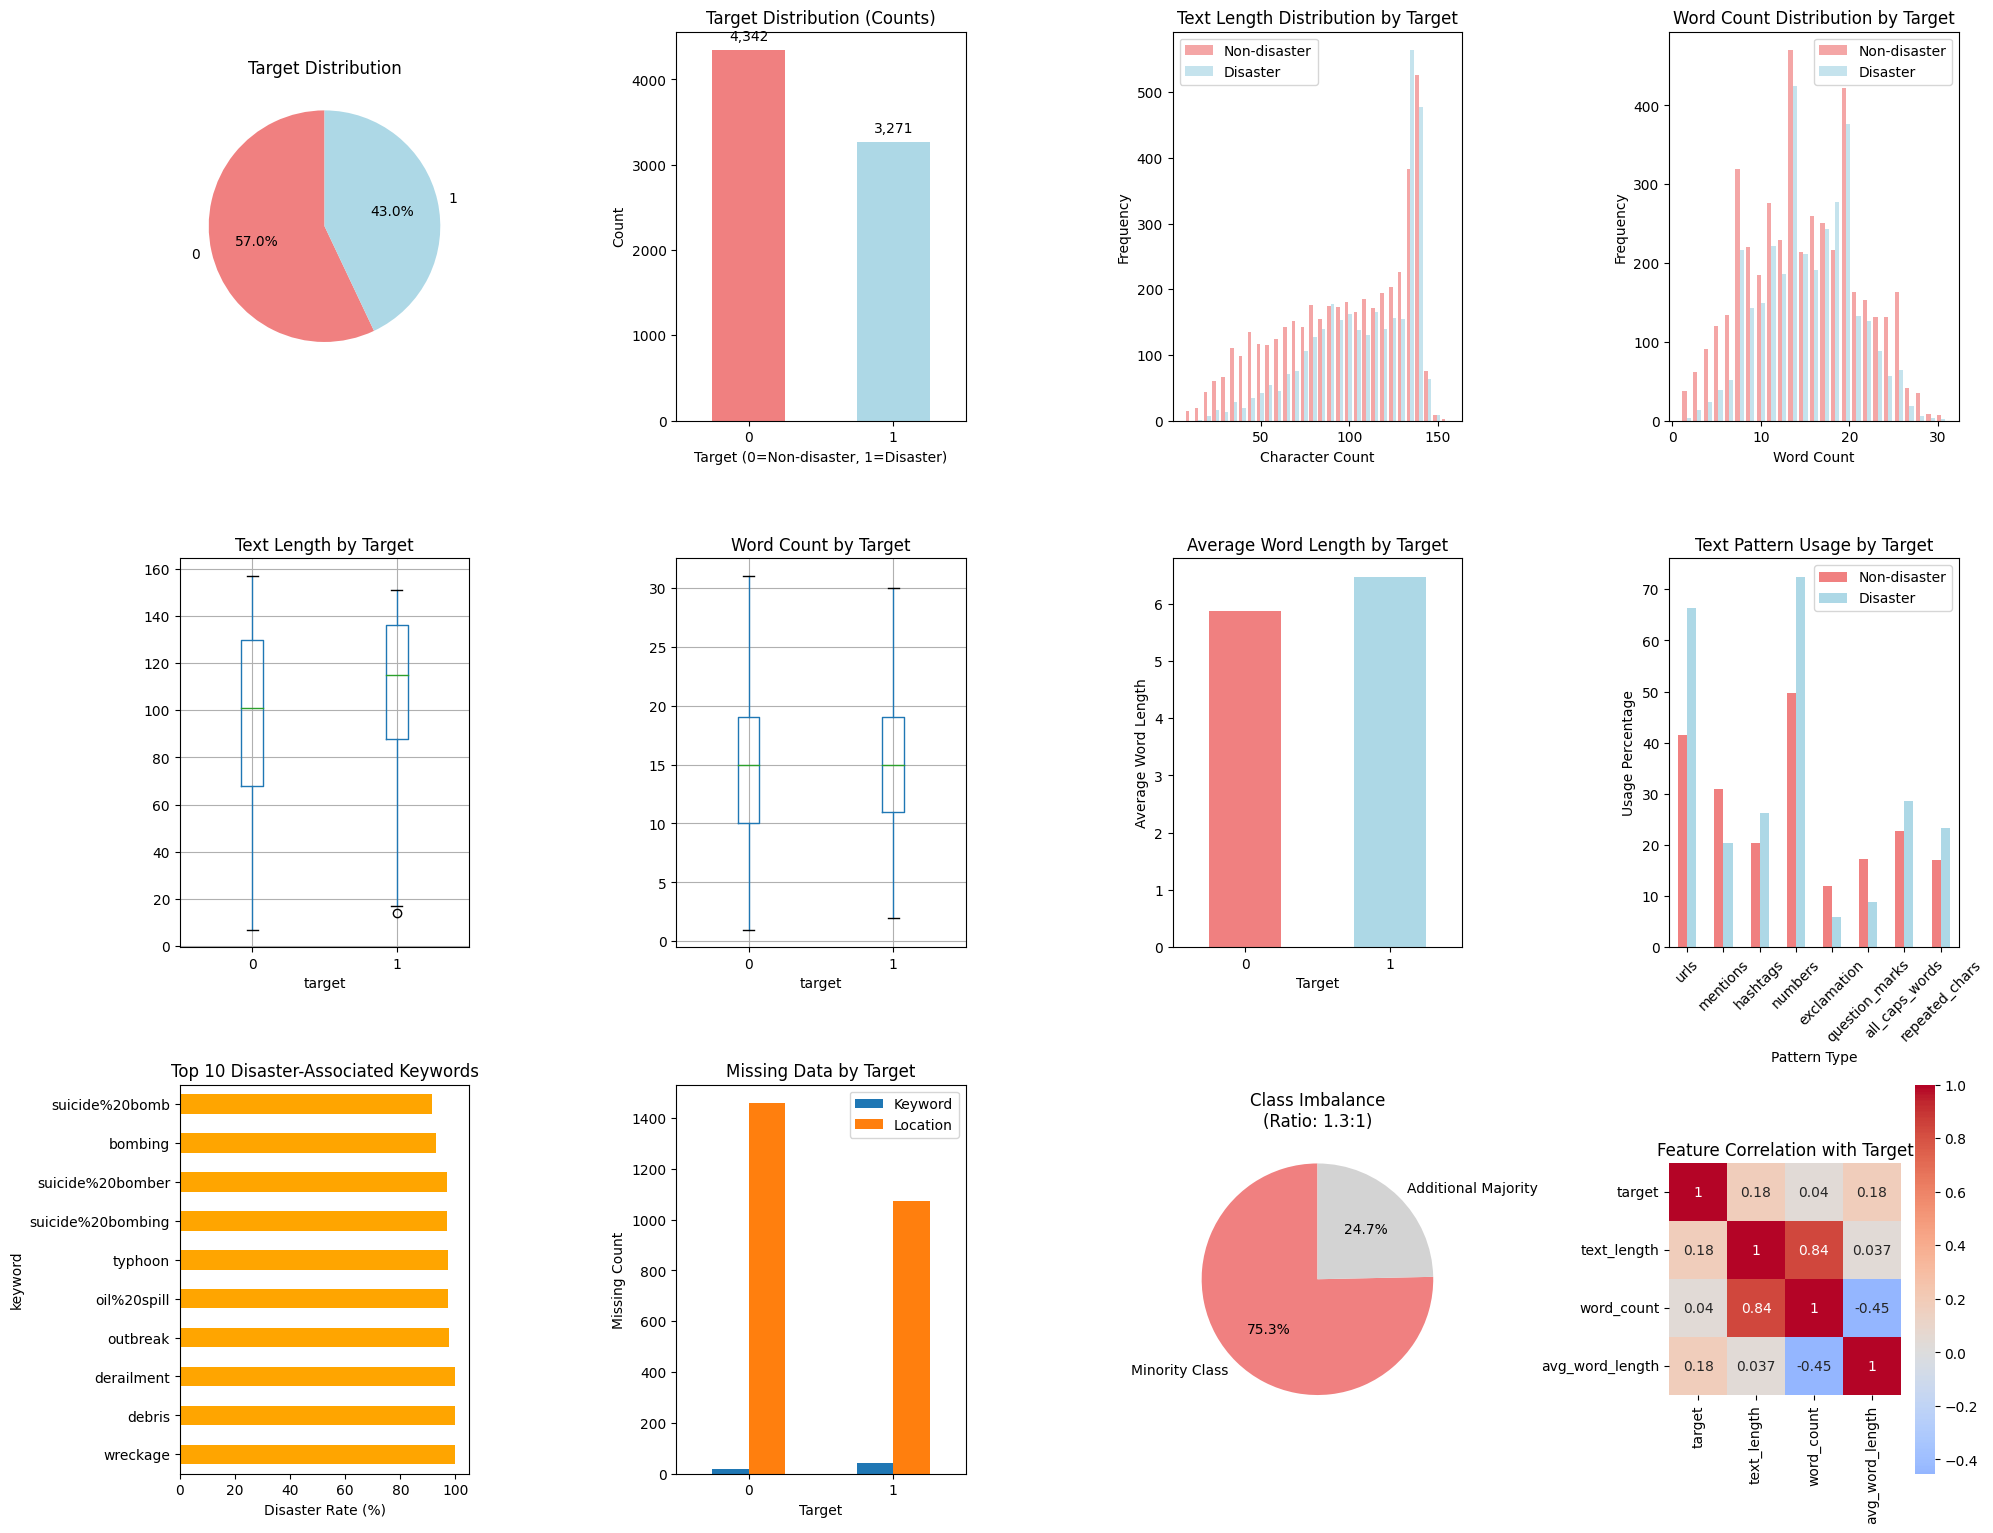

In [6]:
target_results = perform_target_eda(train_df)

### Tweet Analysis

In [7]:
#Text EDA functions

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def analyze_text_feature(df):
    """Comprehensive EDA for the text feature"""
    
    print("=" * 60)
    print("TEXT FEATURE ANALYSIS")
    print("=" * 60)
    
    # 1. Basic Statistics
    print("\n1. BASIC TEXT STATISTICS")
    print("-" * 30)
    print(f"Total tweets: {len(df)}")
    print(f"Missing text: {df['text'].isnull().sum()}")
    print(f"Empty text: {(df['text'] == '').sum()}")
    
    # Calculate text metrics
    df_copy = df.copy()
    df_copy['text_length'] = df_copy['text'].str.len()
    df_copy['word_count'] = df_copy['text'].str.split().str.len()
    df_copy['char_count'] = df_copy['text'].str.len()
    
    # Overall text statistics
    print(f"\nText Length Statistics:")
    print(df_copy['text_length'].describe())
    
    print(f"\nWord Count Statistics:")
    print(df_copy['word_count'].describe())
    
    # 2. Text Statistics by Class
    print("\n2. TEXT STATISTICS BY CLASS")
    print("-" * 35)
    
    for class_val in [0, 1]:
        class_name = "Non-Disaster" if class_val == 0 else "Disaster"
        class_data = df_copy[df_copy['target'] == class_val]
        
        print(f"\n{class_name} tweets:")
        print(f"  Count: {len(class_data)}")
        print(f"  Avg length: {class_data['text_length'].mean():.1f} chars")
        print(f"  Avg words: {class_data['word_count'].mean():.1f} words")
        print(f"  Max length: {class_data['text_length'].max()} chars")
        print(f"  Min length: {class_data['text_length'].min()} chars")
    
    # 3. Character and Pattern Analysis
    print("\n3. CHARACTER AND PATTERN ANALYSIS")
    print("-" * 40)
    
    # Define patterns to analyze
    patterns = {
        'urls': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
        'mentions': r'@\w+',
        'hashtags': r'#\w+',
        'numbers': r'\d+',
        'exclamation': r'!+',
        'question_marks': r'\?+',
        'all_caps_words': r'\b[A-Z]{2,}\b',
        'repeated_chars': r'(.)\1{2,}',
        'emojis': r'[^\w\s,.\'"!?-]'
    }
    
    pattern_stats = {}
    for pattern_name, pattern in patterns.items():
        df_copy[f'has_{pattern_name}'] = df_copy['text'].str.contains(pattern, regex=True, na=False)
        df_copy[f'count_{pattern_name}'] = df_copy['text'].str.findall(pattern).str.len()
        
        total_with_pattern = df_copy[f'has_{pattern_name}'].sum()
        pct_with_pattern = total_with_pattern / len(df_copy) * 100
        avg_count = df_copy[f'count_{pattern_name}'].mean()
        
        pattern_stats[pattern_name] = {
            'total_tweets': total_with_pattern,
            'percentage': pct_with_pattern,
            'avg_count': avg_count
        }
        
        print(f"{pattern_name.replace('_', ' ').title()}: {total_with_pattern} tweets ({pct_with_pattern:.1f}%), avg {avg_count:.2f} per tweet")
    
    # 4. Pattern Analysis by Class
    print("\n4. PATTERN ANALYSIS BY CLASS")
    print("-" * 35)
    
    for pattern_name in patterns.keys():
        disaster_pct = df_copy[df_copy['target'] == 1][f'has_{pattern_name}'].mean() * 100
        non_disaster_pct = df_copy[df_copy['target'] == 0][f'has_{pattern_name}'].mean() * 100
        
        print(f"{pattern_name.replace('_', ' ').title()}:")
        print(f"  Non-Disaster: {non_disaster_pct:.1f}%")
        print(f"  Disaster: {disaster_pct:.1f}%")
        print(f"  Difference: {disaster_pct - non_disaster_pct:+.1f} percentage points")
        print()
    
    return df_copy, pattern_stats

def analyze_vocabulary(df):
    """Analyze vocabulary and word usage patterns"""
    
    print("\n5. VOCABULARY ANALYSIS")
    print("-" * 25)
    
    # Basic vocabulary stats
    all_text = ' '.join(df['text'].fillna(''))
    all_words = re.findall(r'\b\w+\b', all_text.lower())
    
    print(f"Total words: {len(all_words):,}")
    print(f"Unique words: {len(set(all_words)):,}")
    print(f"Vocabulary richness: {len(set(all_words))/len(all_words):.4f}")
    
    # Most common words overall
    word_freq = Counter(all_words)
    print(f"\nTop 15 most common words:")
    for word, freq in word_freq.most_common(15):
        print(f"  {word}: {freq:,}")
    
    # Vocabulary by class
    disaster_text = ' '.join(df[df['target'] == 1]['text'].fillna(''))
    non_disaster_text = ' '.join(df[df['target'] == 0]['text'].fillna(''))
    
    disaster_words = re.findall(r'\b\w+\b', disaster_text.lower())
    non_disaster_words = re.findall(r'\b\w+\b', non_disaster_text.lower())
    
    disaster_vocab = set(disaster_words)
    non_disaster_vocab = set(non_disaster_words)
    
    print(f"\nVocabulary by class:")
    print(f"  Disaster tweets: {len(disaster_vocab):,} unique words")
    print(f"  Non-disaster tweets: {len(non_disaster_vocab):,} unique words")
    print(f"  Shared vocabulary: {len(disaster_vocab & non_disaster_vocab):,} words")
    print(f"  Disaster-only words: {len(disaster_vocab - non_disaster_vocab):,}")
    print(f"  Non-disaster-only words: {len(non_disaster_vocab - disaster_vocab):,}")
    
    # Most discriminative words
    disaster_counter = Counter(disaster_words)
    non_disaster_counter = Counter(non_disaster_words)
    
    print(f"\nTop words in DISASTER tweets:")
    for word, freq in disaster_counter.most_common(10):
        total_freq = word_freq[word]
        disaster_pct = freq / total_freq * 100
        print(f"  {word}: {freq:,} ({disaster_pct:.1f}% of all '{word}' usage)")
    
    print(f"\nTop words in NON-DISASTER tweets:")
    for word, freq in non_disaster_counter.most_common(10):
        total_freq = word_freq[word]
        non_disaster_pct = freq / total_freq * 100
        print(f"  {word}: {freq:,} ({non_disaster_pct:.1f}% of all '{word}' usage)")
    
    return word_freq, disaster_counter, non_disaster_counter

def analyze_text_quality(df):
    """Analyze text quality and preprocessing needs"""
    
    print("\n6. TEXT QUALITY ANALYSIS")
    print("-" * 30)
    
    texts = df['text'].fillna('')
    
    # Quality metrics
    quality_metrics = {
        'empty_or_whitespace': (texts.str.strip() == '').sum(),
        'very_short_tweets': (texts.str.len() < 10).sum(),
        'very_long_tweets': (texts.str.len() > 200).sum(),
        'only_urls': texts.str.match(r'^https?://\S+$').sum(),
        'only_mentions': texts.str.match(r'^@\w+(\s+@\w+)*$').sum(),
        'repeated_text': texts.duplicated().sum(),
        'mostly_numbers': texts.str.replace(r'\D', '', regex=True).str.len().div(texts.str.len()).gt(0.5).sum(),
        'excessive_caps': texts.str.count(r'[A-Z]').div(texts.str.len()).gt(0.5).sum(),
        'excessive_punctuation': texts.str.count(r'[!?.,;:]').div(texts.str.len()).gt(0.3).sum()
    }
    
    print("Potential quality issues:")
    total_tweets = len(df)
    for issue, count in quality_metrics.items():
        if count > 0:
            pct = count / total_tweets * 100
            print(f"  {issue.replace('_', ' ').title()}: {count} ({pct:.1f}%)")
    
    # Character encoding issues
    encoding_issues = {
        'non_ascii': texts.str.contains(r'[^\x00-\x7F]', na=False).sum(),
        'html_entities': texts.str.contains(r'&\w+;', na=False).sum(),
        'unicode_escapes': texts.str.contains(r'\\u[0-9a-fA-F]{4}', na=False).sum()
    }
    
    print(f"\nEncoding and formatting issues:")
    for issue, count in encoding_issues.items():
        if count > 0:
            pct = count / total_tweets * 100
            print(f"  {issue.replace('_', ' ').title()}: {count} ({pct:.1f}%)")

def generate_ngram_analysis(df, n=2, top_k=15):
    """Analyze n-grams in the text"""
    
    print(f"\n7. {n}-GRAM ANALYSIS")
    print("-" * 25)
    
    def get_ngrams(text, n):
        words = re.findall(r'\b\w+\b', text.lower())
        return [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    
    # Overall n-grams
    all_ngrams = []
    for text in df['text'].fillna(''):
        all_ngrams.extend(get_ngrams(text, n))
    
    ngram_counter = Counter(all_ngrams)
    print(f"Top {top_k} {n}-grams overall:")
    for ngram, freq in ngram_counter.most_common(top_k):
        print(f"  '{ngram}': {freq}")
    
    # N-grams by class
    disaster_ngrams = []
    non_disaster_ngrams = []
    
    for text in df[df['target'] == 1]['text'].fillna(''):
        disaster_ngrams.extend(get_ngrams(text, n))
    
    for text in df[df['target'] == 0]['text'].fillna(''):
        non_disaster_ngrams.extend(get_ngrams(text, n))
    
    disaster_ngram_counter = Counter(disaster_ngrams)
    non_disaster_ngram_counter = Counter(non_disaster_ngrams)
    
    print(f"\nTop {top_k//2} {n}-grams in DISASTER tweets:")
    for ngram, freq in disaster_ngram_counter.most_common(top_k//2):
        print(f"  '{ngram}': {freq}")
    
    print(f"\nTop {top_k//2} {n}-grams in NON-DISASTER tweets:")
    for ngram, freq in non_disaster_ngram_counter.most_common(top_k//2):
        print(f"  '{ngram}': {freq}")
    
    return ngram_counter, disaster_ngram_counter, non_disaster_ngram_counter

def visualize_text_analysis(df_with_features):
    """Generate comprehensive visualizations for text analysis"""
    
    fig = plt.figure(figsize=(20, 20))
    
    # 1. Text Length Distribution
    plt.subplot(4, 3, 1)
    disaster_lengths = df_with_features[df_with_features['target'] == 1]['text_length']
    non_disaster_lengths = df_with_features[df_with_features['target'] == 0]['text_length']
    
    plt.hist([non_disaster_lengths, disaster_lengths], bins=30, alpha=0.7, 
             label=['Non-Disaster', 'Disaster'], color=['skyblue', 'coral'])
    plt.title('Text Length Distribution by Class')
    plt.xlabel('Character Count')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 2. Word Count Distribution
    plt.subplot(4, 3, 2)
    disaster_words = df_with_features[df_with_features['target'] == 1]['word_count']
    non_disaster_words = df_with_features[df_with_features['target'] == 0]['word_count']
    
    plt.hist([non_disaster_words, disaster_words], bins=25, alpha=0.7,
             label=['Non-Disaster', 'Disaster'], color=['skyblue', 'coral'])
    plt.title('Word Count Distribution by Class')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 3. URL Usage by Class
    plt.subplot(4, 3, 3)
    url_data = df_with_features.groupby('target')['has_urls'].mean()
    bars = plt.bar(['Non-Disaster', 'Disaster'], url_data.values, color=['skyblue', 'coral'])
    plt.title('URL Usage by Class')
    plt.ylabel('Proportion with URLs')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.2%}', ha='center', va='bottom')
    
    # 4. Hashtag Usage by Class
    plt.subplot(4, 3, 4)
    hashtag_data = df_with_features.groupby('target')['has_hashtags'].mean()
    bars = plt.bar(['Non-Disaster', 'Disaster'], hashtag_data.values, color=['skyblue', 'coral'])
    plt.title('Hashtag Usage by Class')
    plt.ylabel('Proportion with Hashtags')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.2%}', ha='center', va='bottom')
    
    # 5. Mention Usage by Class
    plt.subplot(4, 3, 5)
    mention_data = df_with_features.groupby('target')['has_mentions'].mean()
    bars = plt.bar(['Non-Disaster', 'Disaster'], mention_data.values, color=['skyblue', 'coral'])
    plt.title('Mention Usage by Class')
    plt.ylabel('Proportion with Mentions')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.2%}', ha='center', va='bottom')
    
    # 6. Exclamation Mark Usage
    plt.subplot(4, 3, 6)
    excl_data = df_with_features.groupby('target')['has_exclamation'].mean()
    bars = plt.bar(['Non-Disaster', 'Disaster'], excl_data.values, color=['skyblue', 'coral'])
    plt.title('Exclamation Mark Usage by Class')
    plt.ylabel('Proportion with Exclamation Marks')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.2%}', ha='center', va='bottom')
    
    # 7. All Caps Words Usage
    plt.subplot(4, 3, 7)
    caps_data = df_with_features.groupby('target')['has_all_caps_words'].mean()
    bars = plt.bar(['Non-Disaster', 'Disaster'], caps_data.values, color=['skyblue', 'coral'])
    plt.title('All Caps Words Usage by Class')
    plt.ylabel('Proportion with All Caps Words')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.2%}', ha='center', va='bottom')
    
    # 8. Text Length vs Word Count Scatter
    plt.subplot(4, 3, 8)
    disaster_data = df_with_features[df_with_features['target'] == 1]
    non_disaster_data = df_with_features[df_with_features['target'] == 0]
    
    plt.scatter(non_disaster_data['word_count'], non_disaster_data['text_length'], 
                alpha=0.5, label='Non-Disaster', color='skyblue', s=10)
    plt.scatter(disaster_data['word_count'], disaster_data['text_length'], 
                alpha=0.5, label='Disaster', color='coral', s=10)
    plt.xlabel('Word Count')
    plt.ylabel('Character Count')
    plt.title('Text Length vs Word Count')
    plt.legend()
    
    # 9. Average Pattern Usage Comparison
    plt.subplot(4, 3, 9)
    pattern_cols = [col for col in df_with_features.columns if col.startswith('has_')]
    
    disaster_means = df_with_features[df_with_features['target'] == 1][pattern_cols].mean()
    non_disaster_means = df_with_features[df_with_features['target'] == 0][pattern_cols].mean()
    
    x = np.arange(len(pattern_cols))
    width = 0.35
    
    plt.bar(x - width/2, non_disaster_means.values, width, label='Non-Disaster', color='skyblue')
    plt.bar(x + width/2, disaster_means.values, width, label='Disaster', color='coral')
    
    plt.xlabel('Text Patterns')
    plt.ylabel('Average Usage')
    plt.title('Pattern Usage Comparison')
    plt.xticks(x, [col.replace('has_', '').replace('_', '\n') for col in pattern_cols], rotation=45)
    plt.legend()
    
    # 10. Box plot of text lengths by class
    plt.subplot(4, 3, 10)
    data_to_plot = [non_disaster_lengths, disaster_lengths]
    box_plot = plt.boxplot(data_to_plot, labels=['Non-Disaster', 'Disaster'], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('skyblue')
    box_plot['boxes'][1].set_facecolor('coral')
    plt.title('Text Length Box Plot by Class')
    plt.ylabel('Character Count')
    
    # 11. Cumulative distribution of text lengths
    plt.subplot(4, 3, 11)
    plt.hist(non_disaster_lengths, bins=50, alpha=0.7, cumulative=True, density=True, 
             label='Non-Disaster', color='skyblue')
    plt.hist(disaster_lengths, bins=50, alpha=0.7, cumulative=True, density=True,
             label='Disaster', color='coral')
    plt.title('Cumulative Text Length Distribution')
    plt.xlabel('Character Count')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    
    # 12. Pattern count distribution
    plt.subplot(4, 3, 12)
    count_cols = [col for col in df_with_features.columns if col.startswith('count_')]
    if count_cols:
        total_patterns = df_with_features[count_cols].sum(axis=1)
        disaster_patterns = total_patterns[df_with_features['target'] == 1]
        non_disaster_patterns = total_patterns[df_with_features['target'] == 0]
        
        plt.hist([non_disaster_patterns, disaster_patterns], bins=20, alpha=0.7,
                 label=['Non-Disaster', 'Disaster'], color=['skyblue', 'coral'])
        plt.title('Total Pattern Count Distribution')
        plt.xlabel('Total Pattern Count')
        plt.ylabel('Frequency')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def generate_word_clouds(df):
    """Generate word clouds for disaster and non-disaster tweets"""
    
    print("\n8. GENERATING WORD CLOUDS")
    print("-" * 30)
    
    def clean_text_for_wordcloud(text):
        # Remove URLs, mentions, and hashtags for cleaner word clouds
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text.lower()
    
    # Prepare text by class
    disaster_text = ' '.join([clean_text_for_wordcloud(text) for text in df[df['target'] == 1]['text']])
    non_disaster_text = ' '.join([clean_text_for_wordcloud(text) for text in df[df['target'] == 0]['text']])
    
    # Create word clouds
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Custom stopwords for Twitter
    custom_stopwords = set(['rt', 'amp', 'https', 'http', 'co', 'via', 'the', 'and', 'or', 'but', 
                           'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 
                           'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
                           'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can',
                           'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 
                           'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'its',
                           'our', 'their', 'a', 'an', 'as', 'if', 'so', 'than', 'too', 'very',
                           'just', 'now', 'get', 'got', 'like', 'go', 'going', 'went'])
    
    wordcloud_params = {
        'width': 500,
        'height': 400,
        'background_color': 'white',
        'max_words': 100,
        'stopwords': custom_stopwords,
        'collocations': False,
        'relative_scaling': 0.5
    }
    
    # Non-disaster word cloud
    wc_non_disaster = WordCloud(**wordcloud_params).generate(non_disaster_text)
    axes[0].imshow(wc_non_disaster)
    axes[0].set_title('Non-Disaster Tweets Word Cloud', fontsize=16)
    axes[0].axis('off')
    
    # Disaster word cloud
    wc_disaster = WordCloud(**wordcloud_params).generate(disaster_text)
    axes[1].imshow(wc_disaster)
    axes[1].set_title('Disaster Tweets Word Cloud', fontsize=16)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Main function to run complete text EDA
def run_complete_text_eda(df):
    """Run the complete text EDA pipeline"""
    
    print("Starting comprehensive text EDA...")
    
    # 1. Basic text analysis
    df_with_features, pattern_stats = analyze_text_feature(df)
    
    # 2. Vocabulary analysis
    word_freq, disaster_counter, non_disaster_counter = analyze_vocabulary(df)
    
    # 3. Text quality analysis
    analyze_text_quality(df)
    
    # 4. N-gram analysis
    bigram_analysis = generate_ngram_analysis(df, n=2, top_k=15)
    trigram_analysis = generate_ngram_analysis(df, n=3, top_k=10)
    
    # 5. Generate visualizations
    visualize_text_analysis(df_with_features)
    
    # 6. Generate word clouds
    generate_word_clouds(df)
    
    return {
        'df_with_features': df_with_features,
        'pattern_stats': pattern_stats,
        'word_frequencies': word_freq,
        'disaster_words': disaster_counter,
        'non_disaster_words': non_disaster_counter,
        'bigrams': bigram_analysis,
        'trigrams': trigram_analysis
    }

Starting comprehensive text EDA...
TEXT FEATURE ANALYSIS

1. BASIC TEXT STATISTICS
------------------------------
Total tweets: 7613
Missing text: 0
Empty text: 0

Text Length Statistics:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64

Word Count Statistics:
count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: word_count, dtype: float64

2. TEXT STATISTICS BY CLASS
-----------------------------------

Non-Disaster tweets:
  Count: 4342
  Avg length: 95.7 chars
  Avg words: 14.7 words
  Max length: 157 chars
  Min length: 7 chars

Disaster tweets:
  Count: 3271
  Avg length: 108.1 chars
  Avg words: 15.2 words
  Max length: 151 chars
  Min length: 14 chars

3. CHARACTER AND PATTERN ANALYSIS
-------------------------

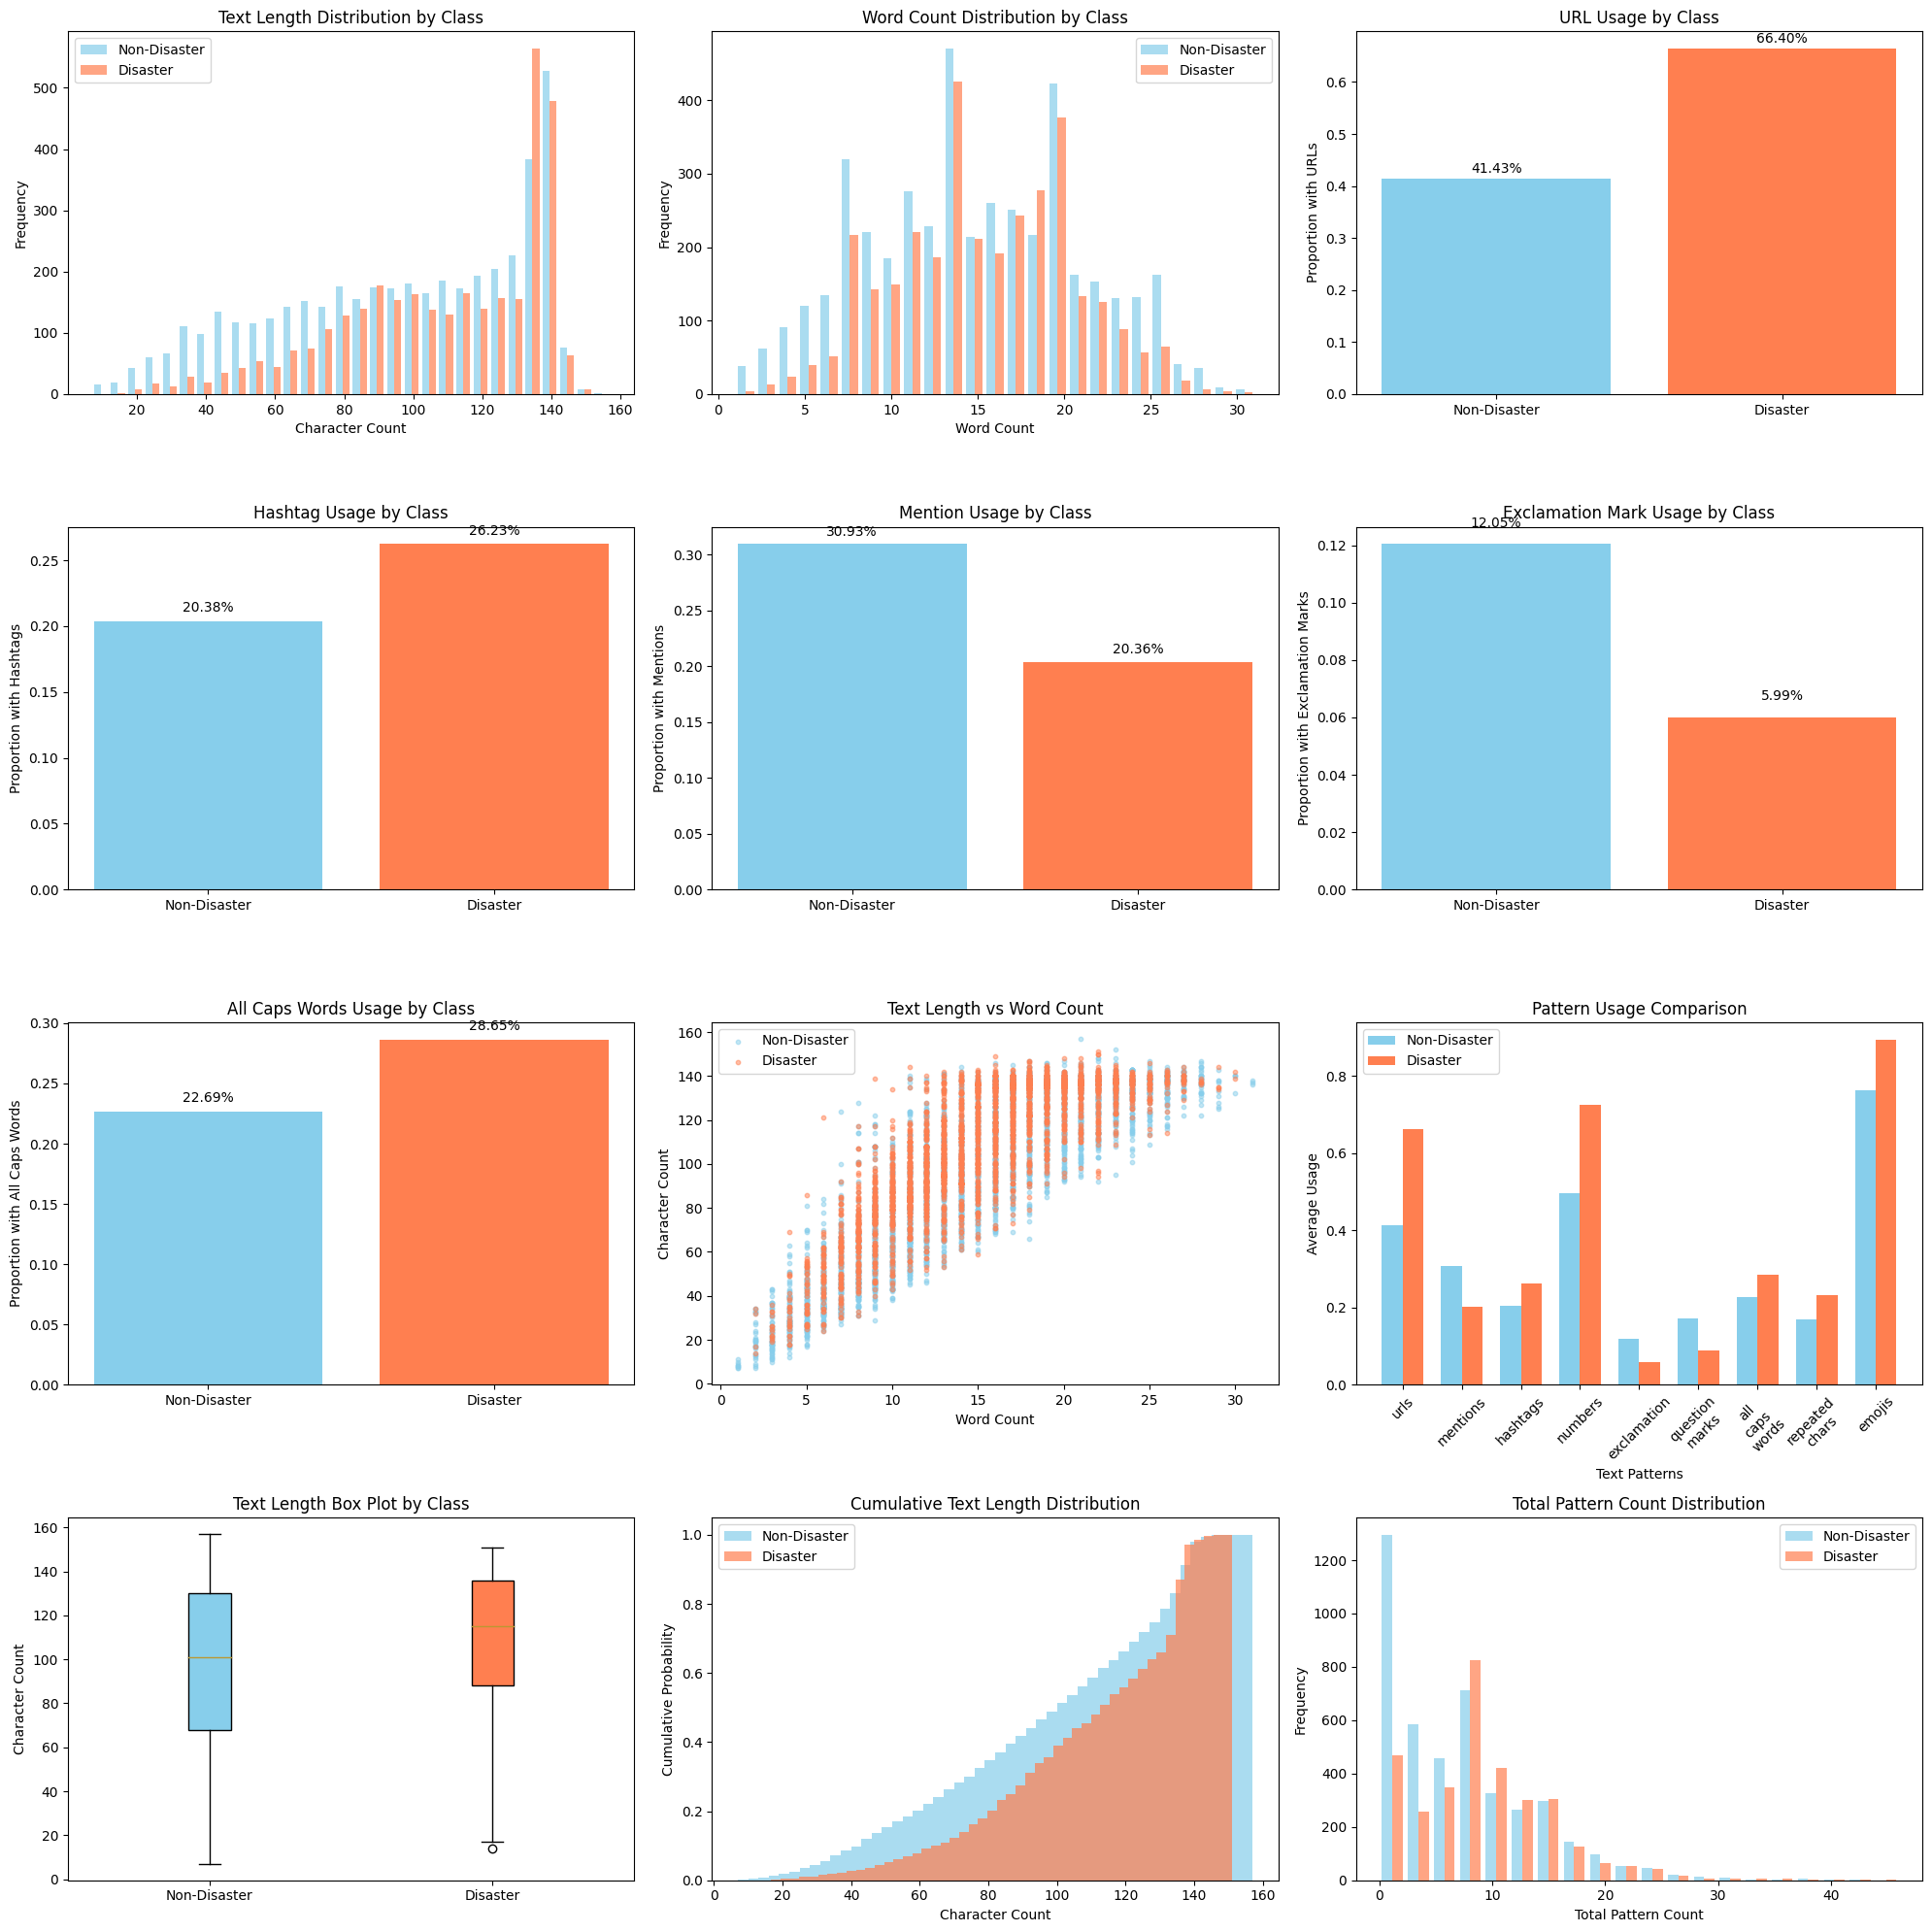


8. GENERATING WORD CLOUDS
------------------------------


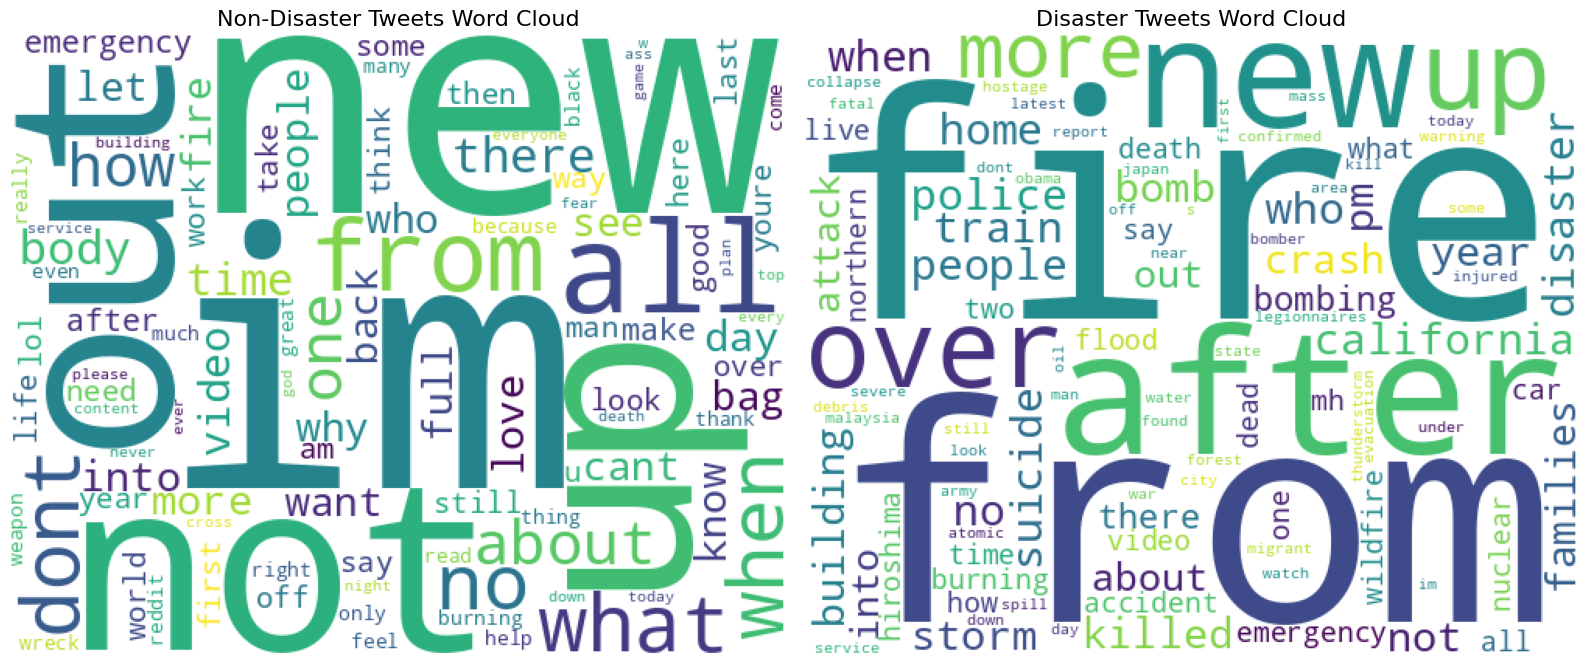

In [8]:
text_analysis_results = run_complete_text_eda(train_df)

### Keyword Analysis

In [9]:
#Keyword EDA functions

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

def analyze_keyword_feature(df):
    """Comprehensive EDA for the keyword feature"""
    
    print("=" * 60)
    print("KEYWORD FEATURE ANALYSIS")
    print("=" * 60)
    
    # 1. Basic Statistics
    print("\n1. BASIC STATISTICS")
    print("-" * 30)
    print(f"Total rows: {len(df)}")
    print(f"Missing keywords: {df['keyword'].isnull().sum()} ({df['keyword'].isnull().mean():.2%})")
    print(f"Unique keywords: {df['keyword'].nunique()}")
    print(f"Rows with keywords: {df['keyword'].notna().sum()}")
    
    # 2. Keyword Distribution
    print("\n2. KEYWORD FREQUENCY DISTRIBUTION")
    print("-" * 40)
    keyword_counts = df['keyword'].value_counts()
    print("Top 10 most frequent keywords:")
    print(keyword_counts.head(10))
    
    # 3. Missing Keywords by Class
    print("\n3. MISSING KEYWORDS BY CLASS")
    print("-" * 35)
    missing_by_class = df.groupby('target')['keyword'].apply(lambda x: x.isnull().sum())
    missing_pct_by_class = df.groupby('target')['keyword'].apply(lambda x: x.isnull().mean())
    
    for class_val in [0, 1]:
        class_name = "Non-Disaster" if class_val == 0 else "Disaster"
        print(f"{class_name}: {missing_by_class[class_val]} missing ({missing_pct_by_class[class_val]:.2%})")
    
    # 4. Keywords by Class Analysis
    print("\n4. KEYWORDS BY CLASS")
    print("-" * 25)
    
    # Filter out missing keywords for this analysis
    df_with_keywords = df[df['keyword'].notna()].copy()
    
    disaster_keywords = df_with_keywords[df_with_keywords['target'] == 1]['keyword'].value_counts()
    non_disaster_keywords = df_with_keywords[df_with_keywords['target'] == 0]['keyword'].value_counts()
    
    print("Top 10 keywords in DISASTER tweets:")
    print(disaster_keywords.head(10))
    print("\nTop 10 keywords in NON-DISASTER tweets:")
    print(non_disaster_keywords.head(10))
    
    # 5. Keyword Effectiveness Analysis
    print("\n5. KEYWORD PREDICTIVE POWER")
    print("-" * 35)
    
    # Calculate disaster rate by keyword
    keyword_disaster_rate = df_with_keywords.groupby('keyword')['target'].agg(['count', 'sum', 'mean']).round(3)
    keyword_disaster_rate.columns = ['total_count', 'disaster_count', 'disaster_rate']
    keyword_disaster_rate = keyword_disaster_rate[keyword_disaster_rate['total_count'] >= 5]  # Filter rare keywords
    keyword_disaster_rate = keyword_disaster_rate.sort_values('disaster_rate', ascending=False)
    
    print("Keywords most likely to indicate REAL disasters (min 5 occurrences):")
    print(keyword_disaster_rate.head(10))
    print("\nKeywords most likely to indicate NON-disasters:")
    print(keyword_disaster_rate.tail(10))
    
    return keyword_disaster_rate

def visualize_keyword_analysis(df, keyword_stats):
    """Generate visualizations for keyword analysis"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Missing Keywords by Class
    plt.subplot(2, 3, 1)
    missing_data = df.groupby('target')['keyword'].apply(lambda x: x.isnull().mean())
    bars = plt.bar(['Non-Disaster', 'Disaster'], missing_data.values)
    plt.title('Missing Keywords by Class')
    plt.ylabel('Proportion Missing')
    plt.ylim(0, 1)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2%}', ha='center', va='bottom')
    
    # 2. Top 15 Most Common Keywords
    plt.subplot(2, 3, 2)
    top_keywords = df['keyword'].value_counts().head(15)
    plt.barh(range(len(top_keywords)), top_keywords.values)
    plt.yticks(range(len(top_keywords)), top_keywords.index)
    plt.title('Top 15 Most Frequent Keywords')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    
    # 3. Keyword Count Distribution
    plt.subplot(2, 3, 3)
    keyword_counts = df['keyword'].value_counts()
    plt.hist(keyword_counts.values, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Keyword Frequencies')
    plt.xlabel('Frequency')
    plt.ylabel('Number of Keywords')
    plt.yscale('log')
    
    # 4. Disaster Rate by Top Keywords
    plt.subplot(2, 3, 4)
    top_predictive = keyword_stats.head(15)
    colors = ['red' if rate > 0.5 else 'blue' for rate in top_predictive['disaster_rate']]
    bars = plt.barh(range(len(top_predictive)), top_predictive['disaster_rate'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_predictive)), top_predictive.index)
    plt.title('Disaster Rate by Keyword (Top 15)')
    plt.xlabel('Disaster Rate')
    plt.gca().invert_yaxis()
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
    
    # 5. Keyword Count vs Disaster Rate Scatter
    plt.subplot(2, 3, 5)
    plt.scatter(keyword_stats['total_count'], keyword_stats['disaster_rate'], alpha=0.6)
    plt.xlabel('Total Keyword Count')
    plt.ylabel('Disaster Rate')
    plt.title('Keyword Frequency vs Disaster Rate')
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 6. Distribution of Disaster Rates
    plt.subplot(2, 3, 6)
    plt.hist(keyword_stats['disaster_rate'], bins=20, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Disaster Rates by Keyword')
    plt.xlabel('Disaster Rate')
    plt.ylabel('Number of Keywords')
    plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def keyword_class_comparison(df):
    """Compare keyword usage between classes"""
    
    df_with_keywords = df[df['keyword'].notna()].copy()
    
    # Get keyword counts by class
    disaster_kw = df_with_keywords[df_with_keywords['target'] == 1]['keyword'].value_counts()
    non_disaster_kw = df_with_keywords[df_with_keywords['target'] == 0]['keyword'].value_counts()
    
    # Combine into comparison dataframe
    comparison = pd.DataFrame({
        'disaster_count': disaster_kw,
        'non_disaster_count': non_disaster_kw
    }).fillna(0)
    
    comparison['total_count'] = comparison['disaster_count'] + comparison['non_disaster_count']
    comparison['disaster_ratio'] = comparison['disaster_count'] / comparison['total_count']
    
    # Filter for keywords with reasonable frequency
    comparison = comparison[comparison['total_count'] >= 10].copy()
    comparison = comparison.sort_values('disaster_ratio', ascending=False)
    
    print("\n6. KEYWORD CLASS COMPARISON")
    print("-" * 35)
    print("Keywords strongly associated with DISASTERS:")
    print(comparison.head(10)[['disaster_count', 'non_disaster_count', 'disaster_ratio']])
    
    print("\nKeywords strongly associated with NON-DISASTERS:")
    print(comparison.tail(10)[['disaster_count', 'non_disaster_count', 'disaster_ratio']])
    
    return comparison

In [10]:
keyword_stats = analyze_keyword_feature(train_df)

KEYWORD FEATURE ANALYSIS

1. BASIC STATISTICS
------------------------------
Total rows: 7613
Missing keywords: 61 (0.80%)
Unique keywords: 221
Rows with keywords: 7552

2. KEYWORD FREQUENCY DISTRIBUTION
----------------------------------------
Top 10 most frequent keywords:
keyword
fatalities     45
armageddon     42
deluge         42
harm           41
damage         41
sinking        41
body%20bags    41
siren          40
windstorm      40
twister        40
Name: count, dtype: int64

3. MISSING KEYWORDS BY CLASS
-----------------------------------
Non-Disaster: 19 missing (0.44%)
Disaster: 42 missing (1.28%)

4. KEYWORDS BY CLASS
-------------------------
Top 10 keywords in DISASTER tweets:
keyword
derailment           39
outbreak             39
wreckage             39
typhoon              37
oil%20spill          37
debris               37
suicide%20bombing    32
suicide%20bomb       32
evacuated            32
rescuers             32
Name: count, dtype: int64

Top 10 keywords in NON-

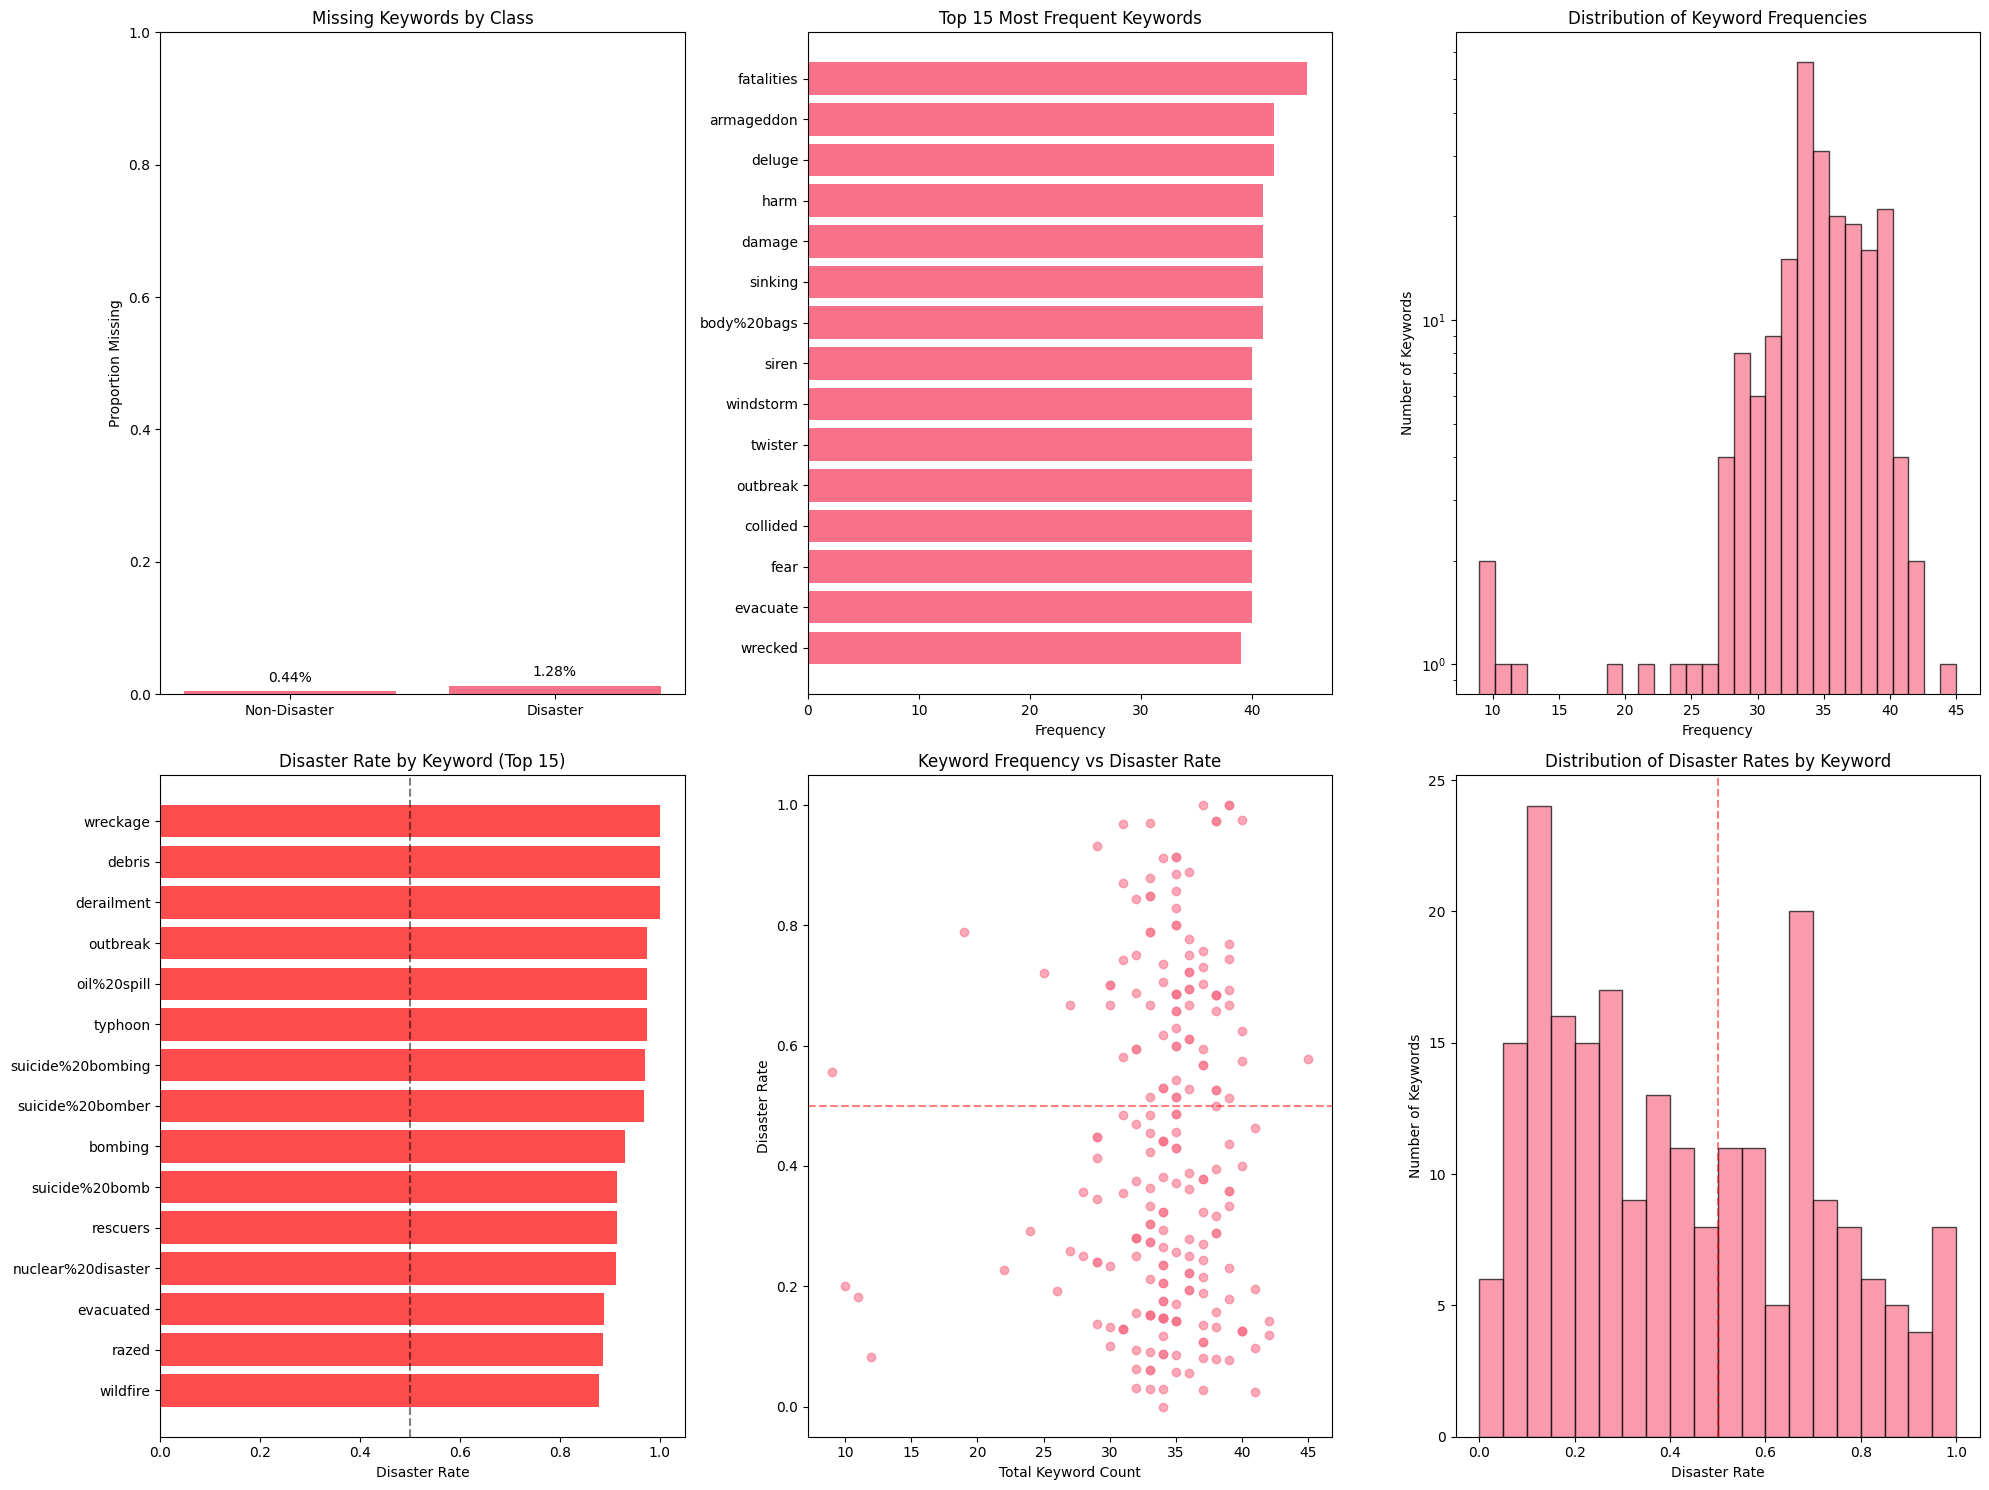

In [11]:
visualize_keyword_analysis(train_df, keyword_stats)

In [12]:
keyword_class_comparison(train_df)


6. KEYWORD CLASS COMPARISON
-----------------------------------
Keywords strongly associated with DISASTERS:
                   disaster_count  non_disaster_count  disaster_ratio
keyword                                                              
wreckage                     39.0                 0.0        1.000000
debris                       37.0                 0.0        1.000000
derailment                   39.0                 0.0        1.000000
outbreak                     39.0                 1.0        0.975000
typhoon                      37.0                 1.0        0.973684
oil%20spill                  37.0                 1.0        0.973684
suicide%20bombing            32.0                 1.0        0.969697
suicide%20bomber             30.0                 1.0        0.967742
bombing                      27.0                 2.0        0.931034
suicide%20bomb               32.0                 3.0        0.914286

Keywords strongly associated with NON-DISASTERS:


,disaster_count,non_disaster_count,total_count,disaster_ratio
keyword,,,,
wreckage,39.0,0.0,39.0,1.000000
debris,37.0,0.0,37.0,1.000000
derailment,39.0,0.0,39.0,1.000000
outbreak,39.0,1.0,40.0,0.975000
typhoon,37.0,1.0,38.0,0.973684
...,...,...,...,...
body%20bag,1.0,32.0,33.0,0.030303
blazing,1.0,33.0,34.0,0.029412
ruin,1.0,36.0,37.0,0.027027


### Location Analysis

In [13]:
#Location EDA functions
plt.style.use('default')
sns.set_palette("husl")

def analyze_location_feature(df):
    """Comprehensive EDA for the location feature"""
    
    print("=" * 60)
    print("LOCATION FEATURE ANALYSIS")
    print("=" * 60)
    
    # 1. Basic Statistics
    print("\n1. BASIC STATISTICS")
    print("-" * 30)
    print(f"Total rows: {len(df)}")
    print(f"Missing locations: {df['location'].isnull().sum()} ({df['location'].isnull().mean():.2%})")
    print(f"Unique locations: {df['location'].nunique()}")
    print(f"Rows with locations: {df['location'].notna().sum()}")
    
    # 2. Location Distribution
    print("\n2. LOCATION FREQUENCY DISTRIBUTION")
    print("-" * 40)
    location_counts = df['location'].value_counts()
    print("Top 15 most frequent locations:")
    print(location_counts.head(15))
    
    # 3. Missing Locations by Class
    print("\n3. MISSING LOCATIONS BY CLASS")
    print("-" * 35)
    missing_by_class = df.groupby('target')['location'].apply(lambda x: x.isnull().sum())
    missing_pct_by_class = df.groupby('target')['location'].apply(lambda x: x.isnull().mean())
    
    for class_val in [0, 1]:
        class_name = "Non-Disaster" if class_val == 0 else "Disaster"
        print(f"{class_name}: {missing_by_class[class_val]} missing ({missing_pct_by_class[class_val]:.2%})")
    
    # 4. Location Length Analysis
    print("\n4. LOCATION LENGTH ANALYSIS")
    print("-" * 35)
    df_with_locations = df[df['location'].notna()].copy()
    df_with_locations['location_length'] = df_with_locations['location'].str.len()
    
    length_stats = df_with_locations['location_length'].describe()
    print("Location length statistics:")
    print(length_stats)
    
    # Length by class
    length_by_class = df_with_locations.groupby('target')['location_length'].describe()
    print("\nLocation length by class:")
    print(length_by_class)
    
    # 5. Locations by Class Analysis
    print("\n5. LOCATIONS BY CLASS")
    print("-" * 25)
    
    disaster_locations = df_with_locations[df_with_locations['target'] == 1]['location'].value_counts()
    non_disaster_locations = df_with_locations[df_with_locations['target'] == 0]['location'].value_counts()
    
    print("Top 10 locations in DISASTER tweets:")
    print(disaster_locations.head(10))
    print("\nTop 10 locations in NON-DISASTER tweets:")
    print(non_disaster_locations.head(10))
    
    # 6. Location Effectiveness Analysis
    print("\n6. LOCATION PREDICTIVE POWER")
    print("-" * 35)
    
    # Calculate disaster rate by location
    location_disaster_rate = df_with_locations.groupby('location')['target'].agg(['count', 'sum', 'mean']).round(3)
    location_disaster_rate.columns = ['total_count', 'disaster_count', 'disaster_rate']
    location_disaster_rate = location_disaster_rate[location_disaster_rate['total_count'] >= 3]  # Filter rare locations
    location_disaster_rate = location_disaster_rate.sort_values('disaster_rate', ascending=False)
    
    print("Locations most likely to indicate REAL disasters (min 3 occurrences):")
    print(location_disaster_rate.head(15))
    print("\nLocations most likely to indicate NON-disasters:")
    print(location_disaster_rate.tail(10))
    
    return df_with_locations, location_disaster_rate

def extract_geographic_patterns(df_with_locations):
    """Extract and analyze geographic patterns from locations"""
    
    print("\n7. GEOGRAPHIC PATTERN ANALYSIS")
    print("-" * 40)
    
    # Create a copy for analysis
    geo_df = df_with_locations.copy()
    geo_df['location_lower'] = geo_df['location'].str.lower()
    
    # Define geographic patterns
    patterns = {
        'usa_states': r'\b(california|texas|florida|new york|washington|oregon|nevada|arizona|colorado|utah|alaska|hawaii|alabama|arkansas|connecticut|delaware|georgia|idaho|illinois|indiana|iowa|kansas|kentucky|louisiana|maine|maryland|massachusetts|michigan|minnesota|mississippi|missouri|montana|nebraska|new hampshire|new jersey|new mexico|north carolina|north dakota|ohio|oklahoma|pennsylvania|rhode island|south carolina|south dakota|tennessee|vermont|virginia|west virginia|wisconsin|wyoming)\b',
        'usa_cities': r'\b(new york|los angeles|chicago|houston|phoenix|philadelphia|san antonio|san diego|dallas|san jose|austin|jacksonville|san francisco|columbus|charlotte|fort worth|detroit|el paso|memphis|seattle|denver|washington|boston|nashville|baltimore|oklahoma city|portland|las vegas|milwaukee|albuquerque|tucson|fresno|sacramento|long beach|kansas city|mesa|atlanta|colorado springs|virginia beach|raleigh|omaha|miami|oakland|tulsa|minneapolis|cleveland|wichita|arlington)\b',
        'countries': r'\b(usa|america|canada|mexico|uk|england|australia|india|nigeria|south africa|kenya|ghana|philippines|indonesia|malaysia|brazil|argentina|france|germany|spain|italy|russia|china|japan|korea|thailand|vietnam)\b',
        'directions': r'\b(north|south|east|west|northern|southern|eastern|western|northeast|northwest|southeast|southwest)\b',
        'geographic_terms': r'\b(city|state|county|province|region|area|coast|mountain|valley|river|lake|beach|island|desert)\b'
    }
    
    # Extract patterns
    for pattern_name, pattern in patterns.items():
        geo_df[f'has_{pattern_name}'] = geo_df['location_lower'].str.contains(pattern, regex=True, na=False)
        pattern_count = geo_df[f'has_{pattern_name}'].sum()
        pattern_disaster_rate = geo_df[geo_df[f'has_{pattern_name}']]['target'].mean()
        print(f"{pattern_name.replace('_', ' ').title()}: {pattern_count} locations ({pattern_disaster_rate:.3f} disaster rate)")
    
    return geo_df

def visualize_location_analysis(df, df_with_locations, location_stats):
    """Generate visualizations for location analysis"""
    
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Missing Locations by Class
    plt.subplot(3, 3, 1)
    missing_data = df.groupby('target')['location'].apply(lambda x: x.isnull().mean())
    bars = plt.bar(['Non-Disaster', 'Disaster'], missing_data.values, color=['skyblue', 'coral'])
    plt.title('Missing Locations by Class')
    plt.ylabel('Proportion Missing')
    plt.ylim(0, 1)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2%}', ha='center', va='bottom')
    
    # 2. Top 20 Most Common Locations
    plt.subplot(3, 3, 2)
    top_locations = df['location'].value_counts().head(20)
    plt.barh(range(len(top_locations)), top_locations.values)
    plt.yticks(range(len(top_locations)), [loc[:25] + '...' if len(loc) > 25 else loc for loc in top_locations.index])
    plt.title('Top 20 Most Frequent Locations')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    
    # 3. Location Length Distribution
    plt.subplot(3, 3, 3)
    df_with_locations['location_length'] = df_with_locations['location'].str.len()
    plt.hist(df_with_locations['location_length'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
    plt.title('Distribution of Location Text Lengths')
    plt.xlabel('Character Length')
    plt.ylabel('Frequency')
    
    # 4. Location Length by Class
    plt.subplot(3, 3, 4)
    disaster_lengths = df_with_locations[df_with_locations['target'] == 1]['location_length']
    non_disaster_lengths = df_with_locations[df_with_locations['target'] == 0]['location_length']
    
    plt.hist([non_disaster_lengths, disaster_lengths], bins=25, alpha=0.7, 
             label=['Non-Disaster', 'Disaster'], color=['skyblue', 'coral'])
    plt.title('Location Length by Class')
    plt.xlabel('Character Length')
    plt.ylabel('Frequency')
    plt.legend()
    
    # 5. Location Count Distribution
    plt.subplot(3, 3, 5)
    location_counts = df['location'].value_counts()
    plt.hist(location_counts.values, bins=50, edgecolor='black', alpha=0.7, color='gold')
    plt.title('Distribution of Location Frequencies')
    plt.xlabel('Frequency')
    plt.ylabel('Number of Locations')
    plt.yscale('log')
    plt.xscale('log')
    
    # 6. Disaster Rate by Top Locations
    plt.subplot(3, 3, 6)
    top_predictive = location_stats.head(20)
    colors = ['red' if rate > 0.5 else 'blue' for rate in top_predictive['disaster_rate']]
    bars = plt.barh(range(len(top_predictive)), top_predictive['disaster_rate'], color=colors, alpha=0.7)
    ytick_labels = [loc[:20] + '...' if len(loc) > 20 else loc for loc in top_predictive.index]
    plt.yticks(range(len(top_predictive)), ytick_labels)
    plt.title('Disaster Rate by Location (Top 20)')
    plt.xlabel('Disaster Rate')
    plt.gca().invert_yaxis()
    plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
    
    # 7. Location Count vs Disaster Rate Scatter
    plt.subplot(3, 3, 7)
    plt.scatter(location_stats['total_count'], location_stats['disaster_rate'], alpha=0.6, color='purple')
    plt.xlabel('Total Location Count')
    plt.ylabel('Disaster Rate')
    plt.title('Location Frequency vs Disaster Rate')
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 8. Distribution of Disaster Rates
    plt.subplot(3, 3, 8)
    plt.hist(location_stats['disaster_rate'], bins=20, edgecolor='black', alpha=0.7, color='orange')
    plt.title('Distribution of Disaster Rates by Location')
    plt.xlabel('Disaster Rate')
    plt.ylabel('Number of Locations')
    plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
    
    # 9. Unique Locations by Class
    plt.subplot(3, 3, 9)
    disaster_unique = df_with_locations[df_with_locations['target'] == 1]['location'].nunique()
    non_disaster_unique = df_with_locations[df_with_locations['target'] == 0]['location'].nunique()
    
    bars = plt.bar(['Non-Disaster', 'Disaster'], [non_disaster_unique, disaster_unique], 
                   color=['skyblue', 'coral'])
    plt.title('Unique Locations by Class')
    plt.ylabel('Number of Unique Locations')
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def analyze_location_quality(df_with_locations):
    """Analyze the quality and patterns in location data"""
    
    print("\n8. LOCATION DATA QUALITY ANALYSIS")
    print("-" * 45)
    
    locations = df_with_locations['location'].copy()
    
    # Pattern analysis
    patterns = {
        'coordinates': r'-?\d+\.\d+.*-?\d+\.\d+',  # Lat/long coordinates
        'urls': r'http[s]?://|www\.',  # URLs
        'unicode_chars': r'[^\x00-\x7F]',  # Non-ASCII characters
        'numbers_only': r'^\d+$',  # Only numbers
        'special_chars': r'[!@#$%^&*()_+=\[\]{}|;:,.<>?/~`]',  # Special characters
        'multiple_words': r'\s+',  # Multiple words
        'all_caps': r'^[A-Z\s]+$',  # All uppercase
        'mixed_case': r'[a-z].*[A-Z]|[A-Z].*[a-z]'  # Mixed case
    }
    
    for pattern_name, pattern in patterns.items():
        count = locations.str.contains(pattern, regex=True, na=False).sum()
        percentage = count / len(locations) * 100
        print(f"{pattern_name.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")
        
        # Show examples
        if count > 0 and count < 10:
            examples = locations[locations.str.contains(pattern, regex=True, na=False)].head(3).tolist()
            print(f"  Examples: {examples}")
    
    # Location length statistics
    print(f"\nLocation length distribution:")
    print(f"Min: {locations.str.len().min()} chars")
    print(f"Max: {locations.str.len().max()} chars")
    print(f"Mean: {locations.str.len().mean():.1f} chars")
    print(f"Median: {locations.str.len().median():.1f} chars")

# Usage functions:
def run_complete_location_eda(df):
    """Run the complete location EDA pipeline"""
    
    # Basic analysis
    df_with_locations, location_stats = analyze_location_feature(df)
    
    # Geographic patterns
    geo_df = extract_geographic_patterns(df_with_locations)
    
    # Data quality
    analyze_location_quality(df_with_locations)
    
    # Visualizations
    visualize_location_analysis(df, df_with_locations, location_stats)
    
    return df_with_locations, location_stats, geo_df

LOCATION FEATURE ANALYSIS

1. BASIC STATISTICS
------------------------------
Total rows: 7613
Missing locations: 2533 (33.27%)
Unique locations: 3341
Rows with locations: 5080

2. LOCATION FREQUENCY DISTRIBUTION
----------------------------------------
Top 15 most frequent locations:
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Chicago, IL         18
Australia           18
Name: count, dtype: int64

3. MISSING LOCATIONS BY CLASS
-----------------------------------
Non-Disaster: 1458 missing (33.58%)
Disaster: 1075 missing (32.86%)

4. LOCATION LENGTH ANALYSIS
-----------------------------------
Location length statistics:
count    5080.000000
mean       13.645669
std         7.072825
min         1.000000
25%         8.000000
5

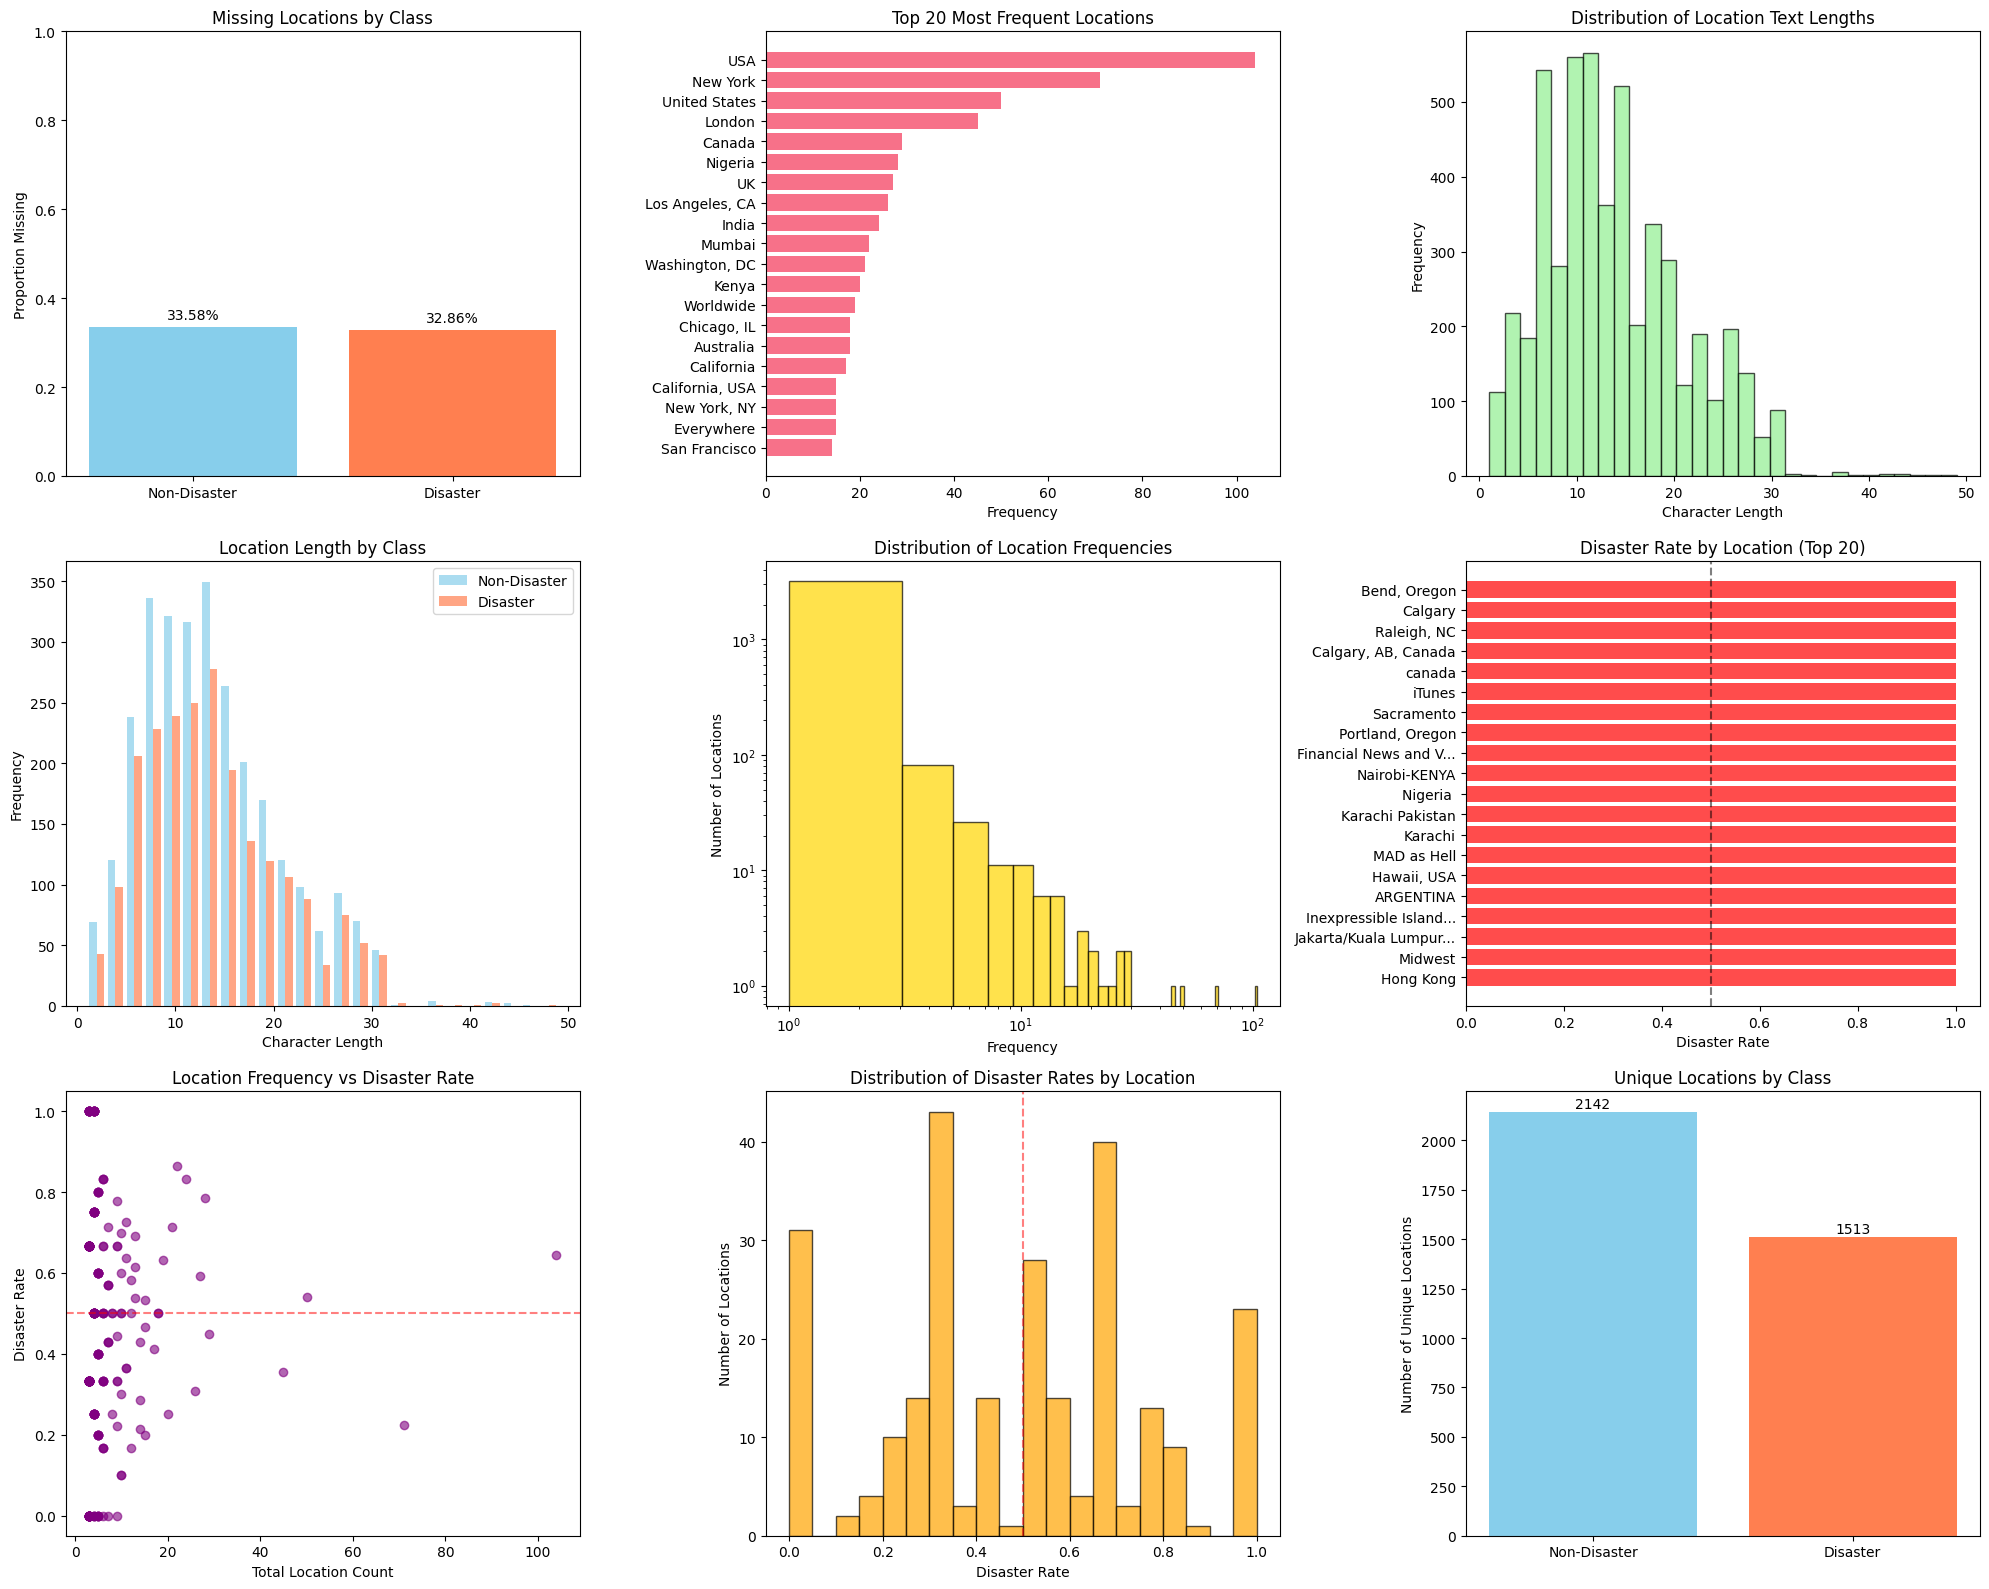

In [14]:
df_with_locations, location_stats, geo_df = run_complete_location_eda(train_df)

## Plan of Analysis

### Recommended Preprocessing Steps based on EDA

1. Vocabulary Management

* Vocabulary size: 10,000-15,000 words (balance between coverage and efficiency)
* OOV handling: Use <OOV> token for unseen words
* Case preservation: Lowercase for better generalization

2. Sequence Length Optimization

* Analyze distribution: Use 95th percentile of sequence lengths
* Typical range: 80-120 tokens for Twitter data
* Padding strategy: Post-padding (pad at end)
* Truncation: Post-truncation (keep beginning of tweets)

3. Text Normalization

* URL replacement: Replace with URL token (preserves context)
* Mention handling: Replace with MENTION token
* Hashtag processing: Keep content, replace # with HASHTAG
* Repeated characters: Normalize but preserve some emphasis

4. Disaster-Specific Preprocessing

* Disaster term normalization: Standardize variations (wildfire, wild fire)
* Preserve important acronyms: Keep emergency-related abbreviations
* Maintain urgency indicators: Keep exclamation patterns

## Data Preprocessning

In [15]:
class DisasterTweetPreprocessor:
    def __init__(self, max_vocab_size=15000, max_sequence_length=140, 
                 oov_token='<OOV>', preserve_case=False):
        self.max_vocab_size = max_vocab_size
        self.max_sequence_length = max_sequence_length
        self.oov_token = oov_token
        self.preserve_case = preserve_case
        self.tokenizer = None
        self.preprocessing_stats = {}
    
    def clean_text(self, text):
        """Clean and normalize text while preserving important information"""
        if pd.isna(text):
            return ""
        
        # Handle URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' <URL> ', text)
        text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' <URL> ', text)
        
        # Handle mentions
        text = re.sub(r'@(\w+)', ' <MENTION> \1', text)
        
        # Handle hashtags
        text = re.sub(r'#(\w+)', r' <HASHTAG> \1 ', text)
        
        # Normalize repeated characters
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        
        # Handle large numbers
        text = re.sub(r'\b\d{4,}\b', ' NUMBER ', text)
        
        # Normalize punctuation
        text = re.sub(r'[!]{2,}', ' !! ', text)
        text = re.sub(r'[?]{2,}', ' ?? ', text)
        text = re.sub(r'\.{2,}', ' ... ', text)
        
        # Handle special quotes - simplified approach
        text = text.replace('"', '"').replace('"', '"')
        text = text.replace(''', "'").replace(''', "'")
        
        # Remove excessive whitespace
        text = re.sub(r'\s+', ' ', text)
        
        # Case normalization
        if not self.preserve_case:
            text = text.lower()
        
        text = text.strip()
        return text
    
    def advanced_text_cleaning(self, texts):
        """Apply advanced cleaning techniques specific to disaster detection"""
        cleaned_texts = []
        
        for text in texts:
            cleaned = self.clean_text(text)
            
            # Normalize common disaster terms - FIXED INDENTATION
            disaster_normalizations = {
                r'\bwildfire\b': 'wildfire',
                r'\bwild fire\b': 'wildfire',
                r'\bearth quake\b': 'earthquake',
                r'\bflash flood\b': 'flashflood',
                r'\btornado\b': 'tornado',
                r'\btwisters?\b': 'tornado',
                r'\bhurricane\b': 'hurricane',
                r'\btyphoon\b': 'hurricane',
                r'\btsunami\b': 'tsunami',
                r'\bvolcano\b': 'volcano',
                r'\bvolcanic\b': 'volcanic'
            }
            
            for pattern, replacement in disaster_normalizations.items():
                cleaned = re.sub(pattern, replacement, cleaned, flags=re.IGNORECASE)
            
            cleaned_texts.append(cleaned)
        
        return cleaned_texts
    
    def fit_tokenizer(self, texts):
        """Fit tokenizer on training texts"""
        print("Fitting tokenizer...")
        
        cleaned_texts = self.advanced_text_cleaning(texts)
        
        self.tokenizer = Tokenizer(
            num_words=self.max_vocab_size,
            oov_token=self.oov_token,
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
        )
        
        self.tokenizer.fit_on_texts(cleaned_texts)
        
        self.preprocessing_stats = {
            'vocab_size': len(self.tokenizer.word_index),
            'effective_vocab_size': min(self.max_vocab_size, len(self.tokenizer.word_index)),
            'oov_token_index': self.tokenizer.word_index.get(self.oov_token, 1),
            'most_common_words': list(self.tokenizer.word_index.items())[:20]
        }
        
        print(f"Vocabulary size: {self.preprocessing_stats['vocab_size']}")
        print(f"Effective vocabulary size: {self.preprocessing_stats['effective_vocab_size']}")
        
        return self
    
    def transform_texts(self, texts):
        """Transform texts to sequences"""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not fitted. Call fit_tokenizer() first.")
        
        cleaned_texts = self.advanced_text_cleaning(texts)
        sequences = self.tokenizer.texts_to_sequences(cleaned_texts)
        
        padded_sequences = pad_sequences(
            sequences, 
            maxlen=self.max_sequence_length,
            padding='post',
            truncating='post'
        )
        
        return padded_sequences, cleaned_texts
    
    def analyze_sequence_lengths(self, texts):
        """Analyze sequence length distribution"""
        cleaned_texts = self.advanced_text_cleaning(texts)
        
        if self.tokenizer is None:
            temp_tokenizer = Tokenizer()
            temp_tokenizer.fit_on_texts(cleaned_texts)
            sequences = temp_tokenizer.texts_to_sequences(cleaned_texts)
        else:
            sequences = self.tokenizer.texts_to_sequences(cleaned_texts)
        
        lengths = [len(seq) for seq in sequences]
        
        stats = {
            'min_length': min(lengths),
            'max_length': max(lengths),
            'mean_length': np.mean(lengths),
            'median_length': np.median(lengths),
            'percentile_90': np.percentile(lengths, 90),
            'percentile_95': np.percentile(lengths, 95),
            'percentile_99': np.percentile(lengths, 99)
        }
        
        print("Sequence Length Analysis:")
        print(f"Min length: {stats['min_length']}")
        print(f"Max length: {stats['max_length']}")
        print(f"Mean length: {stats['mean_length']:.2f}")
        print(f"Median length: {stats['median_length']:.2f}")
        print(f"90th percentile: {stats['percentile_90']:.2f}")
        print(f"95th percentile: {stats['percentile_95']:.2f}")
        print(f"99th percentile: {stats['percentile_99']:.2f}")
        
        recommended_length = int(stats['percentile_95'])
        print(f"\nRecommended max_sequence_length: {recommended_length}")
        
        return stats
    
    def get_preprocessing_report(self):
        """Generate preprocessing report"""
        if not self.preprocessing_stats:
            return "No preprocessing statistics available."
        
        report = f"""
PREPROCESSING REPORT
====================

Tokenizer Configuration:
- Max vocabulary size: {self.max_vocab_size}
- Max sequence length: {self.max_sequence_length}
- Out-of-vocabulary token: {self.oov_token}

Vocabulary Statistics:
- Total vocabulary size: {self.preprocessing_stats['vocab_size']}
- Effective vocabulary size: {self.preprocessing_stats['effective_vocab_size']}

Most Common Words:
"""
        for word, index in self.preprocessing_stats['most_common_words']:
            report += f"- {word}: {index}\n"
        
        return report



In [16]:
#Complete preprocessing pipeline
def preprocess_disaster_tweets(df = train_df, 
                               test_size=TEST_SIZE, 
                               random_state=SEED,
                               max_vocab_size = 15000
                               ):
    
    print("=" * 60)
    print("DISASTER TWEET PREPROCESSING PIPELINE")
    print("=" * 60)
    
    print("\n1. PREPARING DATA")
    print("-" * 20)
    
    df = df.copy()
    df['text'] = df['text'].fillna('')
    df = df[df['text'].str.strip() != '']
    
    print(f"Dataset size: {len(df)} tweets")
    
    print("\n2. ANALYZING SEQUENCE LENGTHS")
    print("-" * 35)
    
    preprocessor = DisasterTweetPreprocessor(
        max_vocab_size=max_vocab_size,
        max_sequence_length=150,
        preserve_case=False
    )
    
    length_stats = preprocessor.analyze_sequence_lengths(df['text'].tolist())
    recommended_length = min(int(length_stats['percentile_95']), 120)
    preprocessor.max_sequence_length = recommended_length
    
    print(f"Using max_sequence_length: {recommended_length}")
    
    print("\n3. SPLITTING DATA")
    print("-" * 20)
    
    X = df['text']
    y = df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    print("\n4. FITTING PREPROCESSOR")
    print("-" * 25)
    
    preprocessor.fit_tokenizer(X_train.tolist())
    
    print("\n5. TRANSFORMING DATA")
    print("-" * 22)
    
    X_train_processed, X_train_cleaned = preprocessor.transform_texts(X_train.tolist())
    X_test_processed, X_test_cleaned = preprocessor.transform_texts(X_test.tolist())
    
    print(f"Training sequences shape: {X_train_processed.shape}")
    print(f"Test sequences shape: {X_test_processed.shape}")
    
    return {
        'X_train': X_train_processed,
        'X_test': X_test_processed,
        'y_train': y_train.values,
        'y_test': y_test.values,
        'preprocessor': preprocessor,
        'tokenizer': preprocessor.tokenizer,
        'length_stats': length_stats
    }



In [17]:
results = preprocess_disaster_tweets(df = train_df, 
                               test_size=.2, 
                               random_state=SEED,
                               max_vocab_size = 15000
                               )

X_train = results['X_train']
X_test = results['X_test']

y_train = results['y_train']
y_test = results['y_test']

preprocessor = results['preprocessor']
tokenizer = results['tokenizer']

DISASTER TWEET PREPROCESSING PIPELINE

1. PREPARING DATA
--------------------
Dataset size: 7613 tweets

2. ANALYZING SEQUENCE LENGTHS
-----------------------------------
Sequence Length Analysis:
Min length: 1
Max length: 35
Mean length: 15.74
Median length: 16.00
90th percentile: 24.00
95th percentile: 26.00
99th percentile: 28.00

Recommended max_sequence_length: 26
Using max_sequence_length: 26

3. SPLITTING DATA
--------------------
Training set: 6090 samples
Test set: 1523 samples

4. FITTING PREPROCESSOR
-------------------------
Fitting tokenizer...
Vocabulary size: 13818
Effective vocabulary size: 13818

5. TRANSFORMING DATA
----------------------
Training sequences shape: (6090, 26)
Test sequences shape: (1523, 26)


## Model Architecture

### Architecture Description

#### Explanation of Architecture

#### Architecture Comparison

### Hyperparameter Tuning

In [18]:
def build_hypermodel1(hp, 
                      vocab_size=13818, 
                      max_sequence_length=26):
    """
    Build hypermodel for Architecture 1 with fixed input dimensions
    
    Use this version when vocab_size and max_sequence_length are 
    determined from preprocessing and should not be tuned.
    
    Args:
        hp: HyperParameters object from keras-tuner
        vocab_size: Fixed vocabulary size from preprocessing
        max_sequence_length: Fixed sequence length from preprocessing
        
    Returns:
        Compiled Keras model ready for training
    """
    
    # Critical Parameters (High Impact)
    embedding_dim = hp.Int('embedding_dim', 
                             min_value = 32,
                             max_value = 128,
                             sampling = 'log',
                             default= 64)
    
    gru_units = hp.Int('gru_units',
                             min_value = 32,
                             max_value = 128,
                             sampling = 'log',
                             default=64)
    
    learning_rate = hp.Float('learning_rate',
                             min_value = 1e-4,
                             max_value = 1e-2,
                             sampling = 'log',
                             default=1e-3)
    
    dropout_rate = hp.Float('dropout_rate',
                             min_value = 0,
                             max_value = .5,
                             sampling = 'linear',
                             default=.25)
    
    # Secondary Parameters (Medium Impact)
    dense_units = hp.Int('dense_units',
                             min_value = 32,
                             max_value = 128,
                             sampling = 'log',
                             default=64)
    # Build the model
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_sequence_length,
            trainable=True,
            name='embedding'
        ),
        
        GRU(
            units=gru_units,
            return_sequences=False,
            name='gru'
        ),
        
        Dropout(
            rate=dropout_rate,
            name='dropout'
        ),
        
        Dense(
            units=dense_units,
            activation='relu',
            name='dense_hidden'
        ),
        
        Dense(
            units=1,
            activation='sigmoid',
            name='output'
        )
    ], name='gru_architecture1')
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model
    

In [19]:
def build_hypermodel2(hp, 
                      vocab_size=13818, 
                      max_sequence_length=26):
    """
    Build hypermodel for Architecture 2 with fixed input dimensions
    
    Args:
        hp: HyperParameters object from keras-tuner
        vocab_size: Fixed vocabulary size from preprocessing
        max_sequence_length: Fixed sequence length from preprocessing
        
    Returns:
        Compiled Keras model ready for training
    """
    
    # Critical Parameters (High Impact)
    embedding_dim = hp.Int('embedding_dim', 
                             min_value = 64,
                             max_value = 256,
                             sampling = 'log',
                             default= 128)
    
    gru1_units = hp.Int('gru1_units',
                             min_value = 64,
                             max_value = 256,
                             sampling = 'log',
                             default=128)
    gru2_units = hp.Int('gru2_units',
                             min_value = 32,
                             max_value = 128,
                             sampling = 'log',
                             default=64)
    
    learning_rate = hp.Float('learning_rate',
                             min_value = 1e-4,
                             max_value = 1e-2,
                             sampling = 'log',
                             default=1e-3)
    
    spatial_dropout_rate = hp.Float('spatial_dropout_rate',
                             min_value = 0,
                             max_value = .5,
                             sampling = 'linear',
                             default=.25)
    
    gru_dropout = hp.Float('gru_dropout',
                             min_value = 0,
                             max_value = .5,
                             sampling = 'linear',
                             default=.25)

    
    
    # Secondary Parameters (Medium Impact)
    dense_units = hp.Int('dense_units',
                             min_value = 64,
                             max_value = 256,
                             sampling = 'log',
                             default=128)
    
    dense_dropout = hp.Float('dense_dropout',
                             min_value = 0,
                             max_value = .5,
                             sampling = 'linear',
                             default=.25)

    recurrent_dropout = hp.Float('recurrent_dropout',
                             min_value = 0,
                             max_value = .5,
                             sampling = 'linear',
                             default=.25)

    # Advanced Parameters
    l2_reg = hp.Float('l2_regularization',
                     min_value = 1e-3,
                     max_value = 1e-1,
                     sampling = 'log',
                     default=1e-2)
    
    batch_norm_momentum = hp.Float('batch_norm_momentum',
                                min_value = .9,
                                max_value = .99,
                                sampling = 'linear',
                                default=.95)
    
    # Build the model
    # Build the model
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    
    # Embedding with spatial dropout
    embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_sequence_length,
        trainable=True,
        name='embedding'
    )(text_input)
    
    embedding_dropout = SpatialDropout1D(spatial_dropout_rate)(embedding)
    
    # First Bidirectional GRU
    gru1 = Bidirectional(
        GRU(
            units=gru1_units,
            return_sequences=True,
            dropout=gru_dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=L2(l2_reg)
        )
    )(embedding_dropout)
    
    gru1_bn = BatchNormalization(momentum=batch_norm_momentum)(gru1)
    
    # Second Bidirectional GRU
    gru2 = Bidirectional(
        GRU(
            units=gru2_units,
            return_sequences=True,
            dropout=gru_dropout,
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=L2(l2_reg)
        )
    )(gru1_bn)
    
    # Multiple pooling strategies
    max_pool = GlobalMaxPooling1D()(gru2)
    avg_pool = GlobalAveragePooling1D()(gru2)
    pooled_features = Concatenate()([max_pool, avg_pool])
    
    # Dense layers with regularization
    dense = Dense(
        units=dense_units,
        activation='relu',
        kernel_regularizer=L2(l2_reg)
    )(pooled_features)
    
    dense_dropout_layer = Dropout(dense_dropout)(dense)
    dense_bn = BatchNormalization(momentum=batch_norm_momentum)(dense_dropout_layer)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(dense_bn)
    
    # Create and compile model
    model = Model(inputs=text_input, outputs=output, name='bidirectional_gru_architecture2')
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model
    

In [20]:
tuner1 = keras_tuner.BayesianOptimization(
    hypermodel=build_hypermodel1,
    objective='val_accuracy',
    max_trials=512,
    num_initial_points=256,
    alpha=0.0001,
    beta=2.6,
    seed=SEED,
    project_name = 'architecture_1',
    overwrite = False,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3
)

I0000 00:00:1750421389.701148      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Reloading Tuner from ./architecture_1/tuner0.json


In [21]:
tuner2 = keras_tuner.BayesianOptimization(
    hypermodel=build_hypermodel2,
    objective='val_accuracy',
    max_trials=64,
    num_initial_points=32,
    alpha=0.0001,
    beta=2.6,
    seed=SEED,
    project_name = 'architecture_2',
    overwrite = False,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=0,
    max_consecutive_failed_trials=3
)

Reloading Tuner from ./architecture_2/tuner0.json


In [22]:
tuner1.search_space_summary()

Search space summary
Default search space size: 5
embedding_dim (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': None, 'sampling': 'log'}
gru_units (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dropout_rate (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
dense_units (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': None, 'sampling': 'log'}


In [23]:
tuner2.search_space_summary()

Search space summary
Default search space size: 11
embedding_dim (Int)
{'default': 128, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': None, 'sampling': 'log'}
gru1_units (Int)
{'default': 128, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': None, 'sampling': 'log'}
gru2_units (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
spatial_dropout_rate (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
gru_dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
dense_units (Int)
{'default': 128, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': None, 'sampling': 'log'}
dense_dropout (Float)
{'default': 0.25, 'conditions': [], 'min_value'

In [24]:
tuner1.search(X_train, y_train, 
             validation_data=(X_test, y_test),
             epochs=10, 
             batch_size = 1024)

In [25]:
tuner2.search(X_train, y_train, 
             validation_data=(X_test, y_test),
             epochs=20, 
             batch_size = 1024)

In [26]:
tuner1.results_summary()

Results summary
Results in ./architecture_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 265 summary
Hyperparameters:
embedding_dim: 38
gru_units: 96
learning_rate: 0.004590329011601276
dropout_rate: 0.3989131768412046
dense_units: 129
Score: 0.8220617175102234

Trial 492 summary
Hyperparameters:
embedding_dim: 45
gru_units: 68
learning_rate: 0.004680569477116696
dropout_rate: 0.5
dense_units: 78
Score: 0.8187787532806396

Trial 273 summary
Hyperparameters:
embedding_dim: 129
gru_units: 129
learning_rate: 0.0030512199312389666
dropout_rate: 0.35844356150305484
dense_units: 32
Score: 0.8187787532806396

Trial 313 summary
Hyperparameters:
embedding_dim: 65
gru_units: 37
learning_rate: 0.005419929505473748
dropout_rate: 0.39541957493481805
dense_units: 42
Score: 0.8187787532806396

Trial 305 summary
Hyperparameters:
embedding_dim: 32
gru_units: 48
learning_rate: 0.003895439835979225
dropout_rate: 0.5
dense_units: 44
Score: 0.818122148513794

Trial 296 summ

In [27]:
tuner2.results_summary()

Results summary
Results in ./architecture_2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 61 summary
Hyperparameters:
embedding_dim: 257
gru1_units: 257
gru2_units: 32
learning_rate: 0.01
spatial_dropout_rate: 0.5
gru_dropout: 0.5
dense_units: 257
dense_dropout: 0.1970415887626817
recurrent_dropout: 0.5
l2_regularization: 0.001
batch_norm_momentum: 0.9
Score: 0.8220617175102234

Trial 46 summary
Hyperparameters:
embedding_dim: 257
gru1_units: 120
gru2_units: 32
learning_rate: 0.01
spatial_dropout_rate: 0.29595731925639907
gru_dropout: 0.2609502113910988
dense_units: 101
dense_dropout: 0.0
recurrent_dropout: 0.5
l2_regularization: 0.001
batch_norm_momentum: 0.9
Score: 0.8161523342132568

Trial 37 summary
Hyperparameters:
embedding_dim: 149
gru1_units: 212
gru2_units: 116
learning_rate: 0.00396098759793493
spatial_dropout_rate: 0.38219026644381604
gru_dropout: 0.44603989739181543
dense_units: 64
dense_dropout: 0.5
recurrent_dropout: 0.11503127926843067
l2_

In [28]:
model2 = tuner2.get_best_models(1)[0]
model1 = tuner1.get_best_models(1)[0]

In [29]:
def generate_kaggle_submission(model,
                               test_df, 
                               preprocessor = preprocessor, 
                               filename=None, threshold=0.5, 
                               validate_format=True):
    """
    Generate a valid Kaggle submission file for disaster tweet classification
    
    Args:
        model: Trained Keras model
        test_df: Test DataFrame containing 'id' and 'text' columns
        preprocessor: Fitted DisasterTweetPreprocessor instance used for training
        filename: Output filename (optional, auto-generated if None)
        threshold: Probability threshold for binary classification (default: 0.5)
        validate_format: Whether to validate submission format (default: True)
        
    Returns:
        pd.DataFrame: Submission dataframe with 'id' and 'target' columns
        
    Raises:
        ValueError: If required columns are missing or preprocessor not fitted
        FileNotFoundError: If unable to save submission file
    """
    
    # Validate inputs
    if not hasattr(preprocessor, 'tokenizer') or preprocessor.tokenizer is None:
        raise ValueError("Preprocessor must be fitted (tokenizer is None)")
    
    required_columns = ['id', 'text']
    missing_columns = [col for col in required_columns if col not in test_df.columns]
    if missing_columns:
        raise ValueError(f"Test DataFrame missing required columns: {missing_columns}")
    
    print("Generating Kaggle submission...")
    print(f"Test samples: {len(test_df)}")
    print(f"Prediction threshold: {threshold}")
    
    # Step 1: Preprocess test data
    print("\n1. Preprocessing test data...")
    try:
        # Transform test texts using the same preprocessor
        X_test_processed, X_test_cleaned = preprocessor.transform_texts(test_df['text'].tolist())
        print(f"   Processed sequences shape: {X_test_processed.shape}")
        print(f"   Sequence length: {X_test_processed.shape[1]}")
        
    except Exception as e:
        raise ValueError(f"Error during preprocessing: {str(e)}")
    
    # Step 2: Generate predictions
    print("\n2. Generating predictions...")
    try:
        # Get prediction probabilities
        pred_probabilities = model.predict(X_test_processed, verbose=1)
        
        # Convert to binary predictions using threshold
        if pred_probabilities.ndim > 1:
            # Handle case where model outputs shape (n, 1)
            pred_probabilities = pred_probabilities.flatten()
        
        binary_predictions = (pred_probabilities >= threshold).astype(int)
        
        print(f"   Prediction probabilities shape: {pred_probabilities.shape}")
        print(f"   Binary predictions shape: {binary_predictions.shape}")
        print(f"   Prediction distribution: {np.bincount(binary_predictions)}")
        
    except Exception as e:
        raise ValueError(f"Error during prediction: {str(e)}")
    
    # Step 3: Create submission dataframe
    print("\n3. Creating submission dataframe...")
    submission_df = pd.DataFrame({
        'id': test_df['id'].values,
        'target': binary_predictions
    })
    
    # Ensure correct data types
    submission_df['id'] = submission_df['id'].astype(int)
    submission_df['target'] = submission_df['target'].astype(int)
    
    print(f"   Submission shape: {submission_df.shape}")
    print(f"   Target value counts:\n{submission_df['target'].value_counts().sort_index()}")
    
    # Step 4: Validate submission format
    if validate_format:
        print("\n4. Validating submission format...")
        validation_errors = []
        
        # Check required columns
        if not all(col in submission_df.columns for col in ['id', 'target']):
            validation_errors.append("Missing required columns: 'id' and/or 'target'")
        
        # Check for missing values
        if submission_df.isnull().any().any():
            validation_errors.append("Submission contains missing values")
        
        # Check target values are binary
        unique_targets = submission_df['target'].unique()
        if not all(target in [0, 1] for target in unique_targets):
            validation_errors.append(f"Target values must be 0 or 1, found: {unique_targets}")
        
        # Check ID uniqueness
        if submission_df['id'].duplicated().any():
            validation_errors.append("Duplicate IDs found in submission")
        
        # Check expected number of samples
        expected_samples = len(test_df)
        actual_samples = len(submission_df)
        if actual_samples != expected_samples:
            validation_errors.append(f"Sample count mismatch: expected {expected_samples}, got {actual_samples}")
        
        if validation_errors:
            raise ValueError("Submission validation failed:\n" + "\n".join(f"- {error}" for error in validation_errors))
        
        print("   ✓ All validation checks passed")
    
    # Step 5: Generate filename and save
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"disaster_tweets_submission_{timestamp}.csv"
    
    # Ensure .csv extension
    if not filename.endswith('.csv'):
        filename += '.csv'
    
    try:
        print(f"\n5. Saving submission to: {filename}")
        submission_df.to_csv(filename, index=False)
        
        # Verify file was created and has correct size
        if os.path.exists(filename):
            file_size = os.path.getsize(filename)
            print(f"   ✓ File saved successfully ({file_size:,} bytes)")
            
            # Quick verification by reading back
            verify_df = pd.read_csv(filename)
            if len(verify_df) == len(submission_df):
                print(f"   ✓ File verification passed ({len(verify_df)} rows)")
            else:
                print(f"   ⚠ Warning: File verification issue (saved {len(verify_df)} rows, expected {len(submission_df)})")
        else:
            raise FileNotFoundError(f"Failed to create submission file: {filename}")
            
    except Exception as e:
        raise FileNotFoundError(f"Error saving submission file: {str(e)}")
    
    # Step 6: Display summary statistics
    print("\n" + "="*60)
    print("SUBMISSION SUMMARY")
    print("="*60)
    print(f"Filename: {filename}")
    print(f"Total predictions: {len(submission_df):,}")
    print(f"Disaster predictions (1): {(submission_df['target'] == 1).sum():,} ({(submission_df['target'] == 1).mean():.1%})")
    print(f"Non-disaster predictions (0): {(submission_df['target'] == 0).sum():,} ({(submission_df['target'] == 0).mean():.1%})")
    print(f"Prediction threshold: {threshold}")
    print(f"Confidence stats:")
    print(f"  Mean probability: {pred_probabilities.mean():.4f}")
    print(f"  Std probability: {pred_probabilities.std():.4f}")
    print(f"  Min probability: {pred_probabilities.min():.4f}")
    print(f"  Max probability: {pred_probabilities.max():.4f}")
    
    # Preview submission
    print(f"\nSubmission preview:")
    print(submission_df.head(10).to_string(index=False))
    print("="*60)
    
    return submission_df

def generate_submission_with_probabilities(model, test_df, preprocessor, 
                                         filename=None, include_probabilities=True):
    """
    Generate submission with optional probability scores for analysis
    
    Args:
        model: Trained Keras model
        test_df: Test DataFrame
        preprocessor: Fitted preprocessor
        filename: Output filename
        include_probabilities: Whether to include probability column
        
    Returns:
        pd.DataFrame: Extended submission with probabilities
    """
    
    # Generate standard submission
    submission_df = generate_kaggle_submission(
        model, test_df, preprocessor, filename=None, validate_format=True
    )
    
    if include_probabilities:
        # Add probabilities for analysis
        X_test_processed, _ = preprocessor.transform_texts(test_df['text'].tolist())
        pred_probabilities = model.predict(X_test_processed, verbose=0)
        
        if pred_probabilities.ndim > 1:
            pred_probabilities = pred_probabilities.flatten()
        
        submission_df['probability'] = pred_probabilities
        submission_df['confidence'] = np.abs(pred_probabilities - 0.5) * 2  # Distance from 0.5, scaled to 0-1
    
    # Save extended version
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"disaster_tweets_submission_extended_{timestamp}.csv"
    
    submission_df.to_csv(filename, index=False)
    print(f"Extended submission saved to: {filename}")
    
    return submission_df

# Usage example
"""
# Load test data
test_df = pd.read_csv('test.csv')

# Generate submission (using results from preprocessing pipeline)
submission = generate_kaggle_submission(
    model=trained_model,
    test_df=test_df, 
    preprocessor=results['preprocessor'],
    filename='my_submission.csv',
    threshold=0.5
)

# Or generate with probabilities for analysis
extended_submission = generate_submission_with_probabilities(
    model=trained_model,
    test_df=test_df,
    preprocessor=results['preprocessor'],
    filename='analysis_submission.csv'
)
"""

"\n# Load test data\ntest_df = pd.read_csv('test.csv')\n\n# Generate submission (using results from preprocessing pipeline)\nsubmission = generate_kaggle_submission(\n    model=trained_model,\n    test_df=test_df, \n    preprocessor=results['preprocessor'],\n    filename='my_submission.csv',\n    threshold=0.5\n)\n\n# Or generate with probabilities for analysis\nextended_submission = generate_submission_with_probabilities(\n    model=trained_model,\n    test_df=test_df,\n    preprocessor=results['preprocessor'],\n    filename='analysis_submission.csv'\n)\n"

In [30]:
test_df.head()
generate_kaggle_submission(model1, test_df, filename = 'submission1.csv')
generate_kaggle_submission(model2, test_df, filename = 'submission2.csv')

Generating Kaggle submission...
Test samples: 3263
Prediction threshold: 0.5

1. Preprocessing test data...
   Processed sequences shape: (3263, 26)
   Sequence length: 26

2. Generating predictions...


I0000 00:00:1750421394.300928     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
   Prediction probabilities shape: (3263,)
   Binary predictions shape: (3263,)
   Prediction distribution: [2140 1123]

3. Creating submission dataframe...
   Submission shape: (3263, 2)
   Target value counts:
target
0    2140
1    1123
Name: count, dtype: int64

4. Validating submission format...
   ✓ All validation checks passed

5. Saving submission to: submission1.csv
   ✓ File saved successfully (22,746 bytes)
   ✓ File verification passed (3263 rows)

SUBMISSION SUMMARY
Filename: submission1.csv
Total predictions: 3,263
Disaster predictions (1): 1,123 (34.4%)
Non-disaster predictions (0): 2,140 (65.6%)
Prediction threshold: 0.5
Confidence stats:
  Mean probability: 0.3797
  Std probability: 0.3737
  Min probability: 0.0049
  Max probability: 0.9978

Submission preview:
 id  target
  0       1
  2       1
  3       1
  9       1
 11       1
 12       1
 21       0
 22       0
 27       0
 29       0
Generating Kaggle submission...
Test sa

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


## Results

In [31]:
#display search results
def compare_tuner_results(tuner1, tuner2, tuner1_name="Architecture 1", tuner2_name="Architecture 2", 
                         save_plots=False, top_n_trials=10):
    """
    Compare and summarize results from two keras-tuner search objects
    
    Args:
        tuner1: First keras-tuner search object
        tuner2: Second keras-tuner search object  
        tuner1_name: Name for first architecture
        tuner2_name: Name for second architecture
        save_plots: Whether to save plots to files
        top_n_trials: Number of top trials to analyze in detail
        
    Returns:
        dict: Comprehensive comparison results
    """
    
    print("=" * 80)
    print("KERAS-TUNER HYPERPARAMETER SEARCH COMPARISON")
    print("=" * 80)
    
    comparison_results = {}
    
    # 1. BASIC SEARCH SUMMARY
    print(f"\n1. BASIC SEARCH SUMMARY")
    print("-" * 35)
    
    # Get basic info about searches
    tuner1_trials = len(tuner1.oracle.trials)
    tuner2_trials = len(tuner2.oracle.trials)
    
    print(f"{tuner1_name}:")
    print(f"  Total trials: {tuner1_trials}")
    print(f"  Objective: {tuner1.oracle.objective.name}")
    print(f"  Direction: {'maximize' if tuner1.oracle.objective.direction == 'max' else 'minimize'}")
    
    print(f"\n{tuner2_name}:")
    print(f"  Total trials: {tuner2_trials}")
    print(f"  Objective: {tuner2.oracle.objective.name}")
    print(f"  Direction: {'maximize' if tuner2.oracle.objective.direction == 'max' else 'minimize'}")
    
    comparison_results['basic_info'] = {
        tuner1_name: {'trials': tuner1_trials, 'objective': tuner1.oracle.objective.name},
        tuner2_name: {'trials': tuner2_trials, 'objective': tuner2.oracle.objective.name}
    }
    
    # 2. BEST HYPERPARAMETERS COMPARISON
    print(f"\n2. BEST HYPERPARAMETERS COMPARISON")
    print("-" * 45)
    
    # Get best hyperparameters
    best_hp1 = tuner1.get_best_hyperparameters(num_trials=1)[0]
    best_hp2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
    
    # Extract all hyperparameter values
    hp1_values = best_hp1.values
    hp2_values = best_hp2.values
    
    # Get all unique hyperparameter names
    all_hp_names = set(hp1_values.keys()) | set(hp2_values.keys())
    
    print(f"Best hyperparameters comparison:")
    print(f"{'Hyperparameter':<25} {tuner1_name:<20} {tuner2_name:<20}")
    print("-" * 70)
    
    hp_comparison = {}
    for hp_name in sorted(all_hp_names):
        val1 = hp1_values.get(hp_name, 'N/A')
        val2 = hp2_values.get(hp_name, 'N/A')
        print(f"{hp_name:<25} {str(val1):<20} {str(val2):<20}")
        hp_comparison[hp_name] = {tuner1_name: val1, tuner2_name: val2}
    
    comparison_results['best_hyperparameters'] = hp_comparison
    
    # 3. PERFORMANCE COMPARISON - FIXED
    print(f"\n3. PERFORMANCE COMPARISON")
    print("-" * 35)
    
    # Get best trial results
    best_trial1 = tuner1.oracle.get_best_trials(num_trials=1)[0]
    best_trial2 = tuner2.oracle.get_best_trials(num_trials=1)[0]
    
    # Extract metrics - CORRECTED METHOD
    def extract_metrics_from_trial(trial):
        """Extract metrics from a trial object"""
        metrics_dict = {}
        
        # Get the metrics from the trial
        if hasattr(trial, 'metrics') and hasattr(trial.metrics, 'metrics'):
            for metric_name, metric_history in trial.metrics.metrics.items():
                if hasattr(metric_history, 'get_best_value'):
                    # Use get_best_value method if available
                    best_value = metric_history.get_best_value()
                    metrics_dict[metric_name] = best_value
                elif hasattr(metric_history, 'values') and len(metric_history.values) > 0:
                    # Get the last value if values list exists
                    metrics_dict[metric_name] = metric_history.values[-1]
                elif hasattr(metric_history, 'value'):
                    # Get the value attribute if it exists
                    metrics_dict[metric_name] = metric_history.value
        
        # Also include the trial score as the main objective
        if hasattr(trial, 'score') and trial.score is not None:
            objective_name = trial.trial_id  # This might need adjustment based on your setup
            metrics_dict['objective_score'] = trial.score
            
        return metrics_dict
    
    metrics1 = extract_metrics_from_trial(best_trial1)
    metrics2 = extract_metrics_from_trial(best_trial2)
    
    # If we couldn't extract metrics properly, try alternative method
    if not metrics1 and not metrics2:
        # Alternative: use the trial score directly
        metrics1 = {'score': best_trial1.score}
        metrics2 = {'score': best_trial2.score}
        
        # Try to get additional metrics from the tuner's results
        try:
            # Get best models to extract their evaluation metrics
            best_model1 = tuner1.get_best_models(num_models=1)[0]
            best_model2 = tuner2.get_best_models(num_models=1)[0]
            
            # Note: You would need validation data to get actual metrics
            # For now, we'll work with what we have
            print("  Note: Limited metrics available - using trial scores")
            
        except Exception as e:
            print(f"  Note: Could not extract detailed metrics: {e}")
    
    print(f"Best trial performance:")
    print(f"{'Metric':<20} {tuner1_name:<20} {tuner2_name:<20} {'Difference':<15}")
    print("-" * 80)
    
    performance_comparison = {}
    all_metrics = set(metrics1.keys()) | set(metrics2.keys())
    
    for metric in sorted(all_metrics):
        val1 = metrics1.get(metric, 'N/A')
        val2 = metrics2.get(metric, 'N/A')
        
        if val1 != 'N/A' and val2 != 'N/A':
            try:
                diff = val2 - val1
                diff_str = f"{diff:+.4f}"
            except (TypeError, ValueError):
                diff_str = 'N/A'
        else:
            diff_str = 'N/A'
        
        # Format values for display
        val1_str = f"{val1:.4f}" if isinstance(val1, (int, float)) else str(val1)
        val2_str = f"{val2:.4f}" if isinstance(val2, (int, float)) else str(val2)
        
        print(f"{metric:<20} {val1_str:<20} {val2_str:<20} {diff_str:<15}")
        performance_comparison[metric] = {
            tuner1_name: val1, 
            tuner2_name: val2, 
            'difference': diff_str
        }
    
    comparison_results['performance'] = performance_comparison
    
    # Determine winner using trial scores
    objective_name = tuner1.oracle.objective.name
    is_maximize = tuner1.oracle.objective.direction == 'max'
    
    score1 = best_trial1.score
    score2 = best_trial2.score
    
    if score1 is not None and score2 is not None:
        if (is_maximize and score2 > score1) or (not is_maximize and score2 < score1):
            winner = tuner2_name
            winner_value = score2
        else:
            winner = tuner1_name
            winner_value = score1
        
        print(f"\n🏆 Best performing architecture: {winner}")
        print(f"   {objective_name}: {winner_value:.4f}")
        comparison_results['winner'] = {'architecture': winner, 'score': winner_value}
    
    # 4. TOP TRIALS ANALYSIS
    print(f"\n4. TOP {top_n_trials} TRIALS ANALYSIS")
    print("-" * 35)
    
    # Get top trials for each tuner
    top_trials1 = tuner1.oracle.get_best_trials(num_trials=top_n_trials)
    top_trials2 = tuner2.oracle.get_best_trials(num_trials=top_n_trials)
    
    # Extract objective scores
    scores1 = [trial.score for trial in top_trials1 if trial.score is not None]
    scores2 = [trial.score for trial in top_trials2 if trial.score is not None]
    
    print(f"{tuner1_name} - Top {len(scores1)} scores:")
    print(f"  Best: {max(scores1) if is_maximize else min(scores1):.4f}")
    print(f"  Mean: {np.mean(scores1):.4f}")
    print(f"  Std:  {np.std(scores1):.4f}")
    
    print(f"\n{tuner2_name} - Top {len(scores2)} scores:")
    print(f"  Best: {max(scores2) if is_maximize else min(scores2):.4f}")
    print(f"  Mean: {np.mean(scores2):.4f}")
    print(f"  Std:  {np.std(scores2):.4f}")
    
    comparison_results['top_trials'] = {
        tuner1_name: {'scores': scores1, 'mean': np.mean(scores1), 'std': np.std(scores1)},
        tuner2_name: {'scores': scores2, 'mean': np.mean(scores2), 'std': np.std(scores2)}
    }
    
    # 5. HYPERPARAMETER DISTRIBUTION ANALYSIS
    print(f"\n5. HYPERPARAMETER DISTRIBUTION ANALYSIS")
    print("-" * 45)
    
    # Extract all trial hyperparameters
    def extract_trial_hyperparameters(tuner, top_n=None):
        trials = tuner.oracle.get_best_trials(num_trials=top_n) if top_n else list(tuner.oracle.trials.values())
        trial_hps = []
        for trial in trials:
            if trial.score is not None:  # Only include completed trials
                hp_dict = trial.hyperparameters.values.copy()
                hp_dict['score'] = trial.score
                trial_hps.append(hp_dict)
        return pd.DataFrame(trial_hps)
    
    trials_df1 = extract_trial_hyperparameters(tuner1, top_n_trials)
    trials_df2 = extract_trial_hyperparameters(tuner2, top_n_trials)
    
    # Analyze hyperparameter importance (correlation with score)
    print(f"Hyperparameter importance (correlation with {objective_name}):")
    
    numeric_cols1 = trials_df1.select_dtypes(include=[np.number]).columns
    numeric_cols2 = trials_df2.select_dtypes(include=[np.number]).columns
    
    if 'score' in numeric_cols1 and len(numeric_cols1) > 1:
        correlations1 = trials_df1[numeric_cols1].corr()['score'].drop('score').abs().sort_values(ascending=False)
        print(f"\n{tuner1_name} (top correlations):")
        for hp, corr in correlations1.head(5).items():
            print(f"  {hp}: {corr:.3f}")
    
    if 'score' in numeric_cols2 and len(numeric_cols2) > 1:
        correlations2 = trials_df2[numeric_cols2].corr()['score'].drop('score').abs().sort_values(ascending=False)
        print(f"\n{tuner2_name} (top correlations):")
        for hp, corr in correlations2.head(5).items():
            print(f"  {hp}: {corr:.3f}")
    
    # 6. CONVERGENCE ANALYSIS
    print(f"\n6. CONVERGENCE ANALYSIS")
    print("-" * 25)
    
    # Get trial scores in chronological order
    all_trials1 = [trial for trial in tuner1.oracle.trials.values() if trial.score is not None]
    all_trials2 = [trial for trial in tuner2.oracle.trials.values() if trial.score is not None]
    
    # Sort by trial_id to get chronological order
    all_trials1.sort(key=lambda x: int(x.trial_id))
    all_trials2.sort(key=lambda x: int(x.trial_id))
    
    scores_chronological1 = [trial.score for trial in all_trials1]
    scores_chronological2 = [trial.score for trial in all_trials2]
    
    # Calculate cumulative best scores
    if is_maximize:
        cumulative_best1 = np.maximum.accumulate(scores_chronological1)
        cumulative_best2 = np.maximum.accumulate(scores_chronological2)
    else:
        cumulative_best1 = np.minimum.accumulate(scores_chronological1)
        cumulative_best2 = np.minimum.accumulate(scores_chronological2)
    
    # Calculate improvement rate (how often score improved)
    improvements1 = np.diff(cumulative_best1) != 0
    improvements2 = np.diff(cumulative_best2) != 0
    
    improvement_rate1 = np.sum(improvements1) / len(improvements1) if len(improvements1) > 0 else 0
    improvement_rate2 = np.sum(improvements2) / len(improvements2) if len(improvements2) > 0 else 0
    
    print(f"{tuner1_name}:")
    print(f"  Improvement rate: {improvement_rate1:.2%}")
    print(f"  Final best score: {cumulative_best1[-1]:.4f}")
    print(f"  Total completed trials: {len(scores_chronological1)}")
    
    print(f"\n{tuner2_name}:")
    print(f"  Improvement rate: {improvement_rate2:.2%}")
    print(f"  Final best score: {cumulative_best2[-1]:.4f}")
    print(f"  Total completed trials: {len(scores_chronological2)}")
    
    comparison_results['convergence'] = {
        tuner1_name: {
            'improvement_rate': improvement_rate1,
            'final_best': cumulative_best1[-1],
            'cumulative_best': cumulative_best1.tolist(),
            'total_trials': len(scores_chronological1)
        },
        tuner2_name: {
            'improvement_rate': improvement_rate2,
            'final_best': cumulative_best2[-1],
            'cumulative_best': cumulative_best2.tolist(),
            'total_trials': len(scores_chronological2)
        }
    }
    
    # 7. GENERATE COMPREHENSIVE VISUALIZATIONS
    print(f"\n7. GENERATING VISUALIZATIONS")
    print("-" * 35)
    
    fig = plt.figure(figsize=(20, 16))
    
    # Best scores comparison
    plt.subplot(3, 4, 1)
    best_scores = [cumulative_best1[-1], cumulative_best2[-1]]
    bars = plt.bar([tuner1_name, tuner2_name], best_scores, 
                   color=['skyblue', 'lightcoral'], alpha=0.8)
    plt.title('Best Scores Comparison')
    plt.ylabel(f'{objective_name}')
    plt.xticks(rotation=45)
    
    # Add values on bars
    for i, (bar, score) in enumerate(zip(bars, best_scores)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{score:.4f}', ha='center', va='bottom')
    
    # Top scores distribution
    plt.subplot(3, 4, 2)
    plt.hist([scores1, scores2], bins=15, alpha=0.7, label=[tuner1_name, tuner2_name],
             color=['skyblue', 'lightcoral'])
    plt.xlabel(f'{objective_name}')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n_trials} Scores Distribution')
    plt.legend()
    
    # Convergence curves
    plt.subplot(3, 4, 3)
    plt.plot(range(1, len(cumulative_best1) + 1), cumulative_best1, 
             label=tuner1_name, marker='o', markersize=3, color='skyblue')
    plt.plot(range(1, len(cumulative_best2) + 1), cumulative_best2, 
             label=tuner2_name, marker='s', markersize=3, color='lightcoral')
    plt.xlabel('Trial Number')
    plt.ylabel(f'Best {objective_name}')
    plt.title('Convergence Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Score scatter plot
    plt.subplot(3, 4, 4)
    plt.scatter(range(len(scores_chronological1)), scores_chronological1, 
               alpha=0.6, label=tuner1_name, s=30, color='skyblue')
    plt.scatter(range(len(scores_chronological2)), scores_chronological2, 
               alpha=0.6, label=tuner2_name, s=30, color='lightcoral')
    plt.xlabel('Trial Number')
    plt.ylabel(f'{objective_name}')
    plt.title('All Trial Scores')
    plt.legend()
    
    # Score improvement over time
    plt.subplot(3, 4, 5)
    plt.plot(range(1, len(scores_chronological1) + 1), scores_chronological1, 
             alpha=0.3, color='blue', linewidth=1)
    plt.plot(range(1, len(cumulative_best1) + 1), cumulative_best1, 
             color='blue', linewidth=2, label=f'{tuner1_name} (best)')
    
    plt.plot(range(1, len(scores_chronological2) + 1), scores_chronological2, 
             alpha=0.3, color='red', linewidth=1)
    plt.plot(range(1, len(cumulative_best2) + 1), cumulative_best2, 
             color='red', linewidth=2, label=f'{tuner2_name} (best)')
    
    plt.xlabel('Trial Number')
    plt.ylabel(f'{objective_name}')
    plt.title('Score Progress (Individual + Best-so-far)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Performance metrics comparison
    plt.subplot(3, 4, 6)
    comparison_metrics = ['Best Score', 'Mean Top 10', 'Std Top 10']
    values1 = [cumulative_best1[-1], np.mean(scores1), np.std(scores1)]
    values2 = [cumulative_best2[-1], np.mean(scores2), np.std(scores2)]
    
    x = np.arange(len(comparison_metrics))
    width = 0.35
    
    plt.bar(x - width/2, values1, width, label=tuner1_name, alpha=0.8, color='skyblue')
    plt.bar(x + width/2, values2, width, label=tuner2_name, alpha=0.8, color='lightcoral')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, comparison_metrics)
    plt.legend()
    
    # Trial efficiency comparison
    plt.subplot(3, 4, 7)
    efficiency1 = cumulative_best1[-1] / len(all_trials1) if len(all_trials1) > 0 else 0
    efficiency2 = cumulative_best2[-1] / len(all_trials2) if len(all_trials2) > 0 else 0
    
    bars = plt.bar([tuner1_name, tuner2_name], [efficiency1, efficiency2], 
                   color=['skyblue', 'lightcoral'], alpha=0.8)
    plt.ylabel('Score per Trial')
    plt.title('Search Efficiency')
    plt.xticks(rotation=45)
    
    # Add efficiency values on bars
    for i, (bar, eff) in enumerate(zip(bars, [efficiency1, efficiency2])):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{eff:.5f}', ha='center', va='bottom')
    
    # Improvement rate comparison
    plt.subplot(3, 4, 8)
    bars = plt.bar([tuner1_name, tuner2_name], [improvement_rate1, improvement_rate2], 
                   color=['skyblue', 'lightcoral'], alpha=0.8)
    plt.ylabel('Improvement Rate')
    plt.title('Convergence Speed')
    plt.xticks(rotation=45)
    
    # Add values on bars
    for i, (bar, rate) in enumerate(zip(bars, [improvement_rate1, improvement_rate2])):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{rate:.1%}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('tuner_comparison_analysis.png', dpi=300, bbox_inches='tight')
        print("Comparison plots saved to 'tuner_comparison_analysis.png'")
    
    plt.show()
    
    return comparison_results

KERAS-TUNER HYPERPARAMETER SEARCH COMPARISON

1. BASIC SEARCH SUMMARY
-----------------------------------
Simple GRU (Architecture 1):
  Total trials: 512
  Objective: val_accuracy
  Direction: maximize

Bidirectional GRU (Architecture 2):
  Total trials: 64
  Objective: val_accuracy
  Direction: maximize

2. BEST HYPERPARAMETERS COMPARISON
---------------------------------------------
Best hyperparameters comparison:
Hyperparameter            Simple GRU (Architecture 1) Bidirectional GRU (Architecture 2)
----------------------------------------------------------------------
batch_norm_momentum       N/A                  0.9                 
dense_dropout             N/A                  0.1970415887626817  
dense_units               129                  257                 
dropout_rate              0.3989131768412046   N/A                 
embedding_dim             38                   257                 
gru1_units                N/A                  257                 
gru2_units

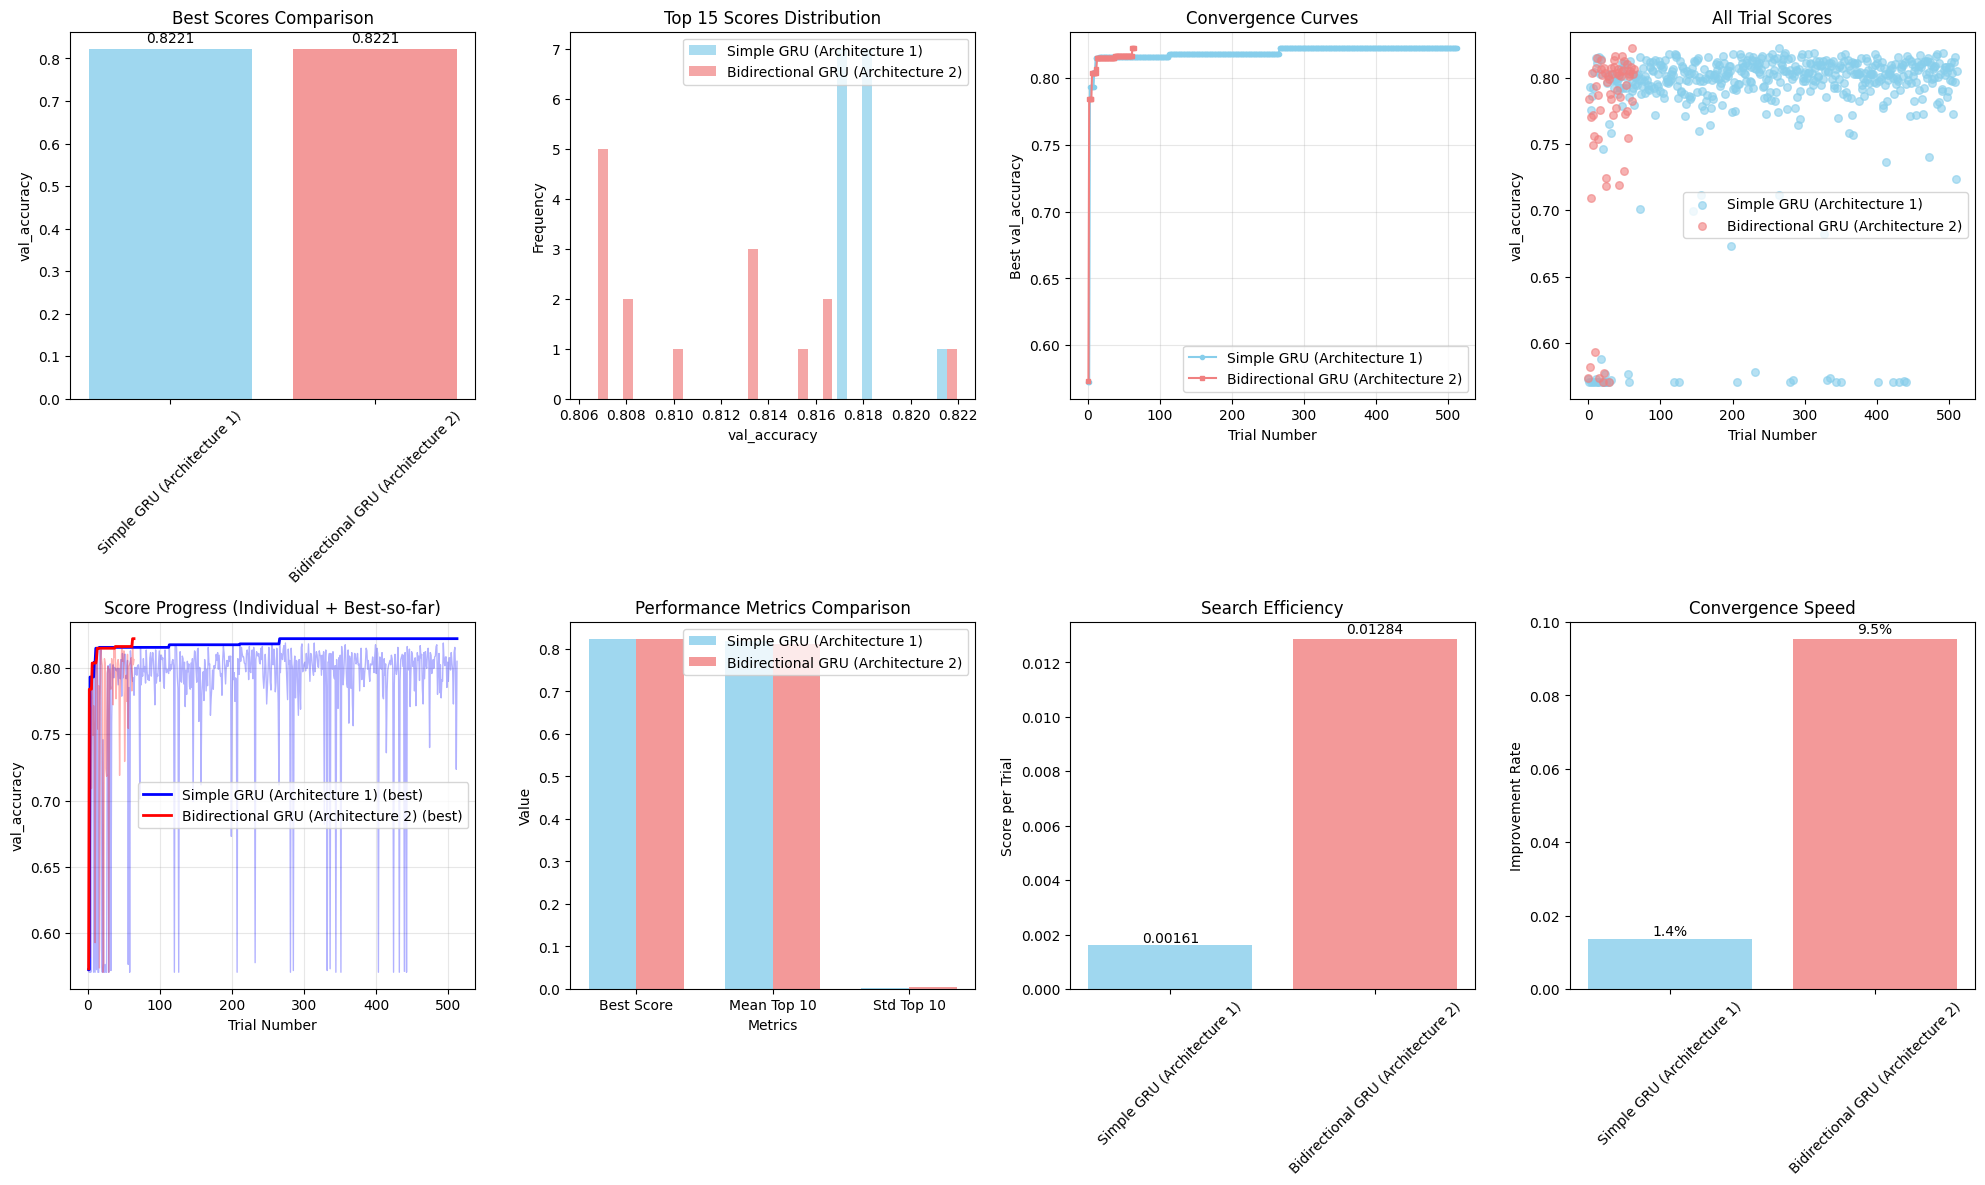

In [32]:
comparison_results = compare_tuner_results(
    tuner1, tuner2, 
    tuner1_name="Simple GRU (Architecture 1)",
    tuner2_name="Bidirectional GRU (Architecture 2)",
    top_n_trials=15
)

### Competition Results
Architecture 1: .799


Architecture 2: .794

## Analysis

Both the simple and bidirectional models achieved nearly identical performance on the validation and competition sets despite large differences in model complexities. However, during the Bayesian search of the hyperparameter space, several of the hyperparameters for both models were driven to the edge of the search space for the respective parameters. This indicates that the performance of the models was not limited by their complexity but by a poor choice of hyperparameters for each model. As such, it is not possible to accurately compare the two architectures without performing additional testing with an expanded search space. 

## Conclusion

The goal of this project was to use Recurrent Neural Nets in the context of Natural Language Processing to classify tweets as either referring to a real disaster or not. Exploratory data analysis revealed several significant differences between the disaster tweets and non-disaster and revealed numerous ways in which the data could be cleaned. The tweets were then fed through a comprehensive preprocessing pipeline to clean and vectorize them. Two different model architectures were constructed to analyze the cleaned tweets. One was a simplistic model with a single unidirectional GRU layer and a limited number of hyperparameters. The second was more complicated with 2 bidirectional GRU layers and additional tunable parameters. Despite the difference in complexity the models performed nearly identically on both the validation and competition data sets achieving competition scores of .799 and .794 respectively.